**Ce notebook contient les tests réalisés pour déterminer les caractéristiques de segmentations ainsi que l'algorythme de clustering optimal.**

# Initialisation

In [2]:
# basis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# data
from google.colab import drive
drive.mount('/content/drive')

# timing managment
from tqdm import tqdm
from time import time

# Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Transformation
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

Mounted at /content/drive


In [10]:
path_data = '/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 5/olist_data/'
RFM_df_numeric = pd.read_csv(path_data + 'Segmentation_tab.csv').drop('customer_unique_id', axis= 1)

In [63]:
RFM_df_numeric.head()

recency  frequency  monetary  satisfaction_mean  installment_mean  \
0  115.923958          1    141.90                5.0               8.0   
1  118.913542          1     27.19                4.0               1.0   
2  541.501319          1     86.22                3.0               8.0   
3  325.525880          1     43.62                4.0               4.0   
4  292.556424          1    196.89                5.0               6.0   

      distance  product_category_name_english  main_state  
0   110.496092                             74          27  
1    22.190341                             72          27  
2   515.379484                             56           8  
3  2468.983992                             61          23  
4   154.744091                             61          27

In [64]:
RFM_df_numeric.describe()

recency     frequency      monetary  satisfaction_mean  \
count  94304.000000  94304.000000  94304.000000       94304.000000   
mean     242.933499      1.039373    166.160287           4.114092   
std      152.999640      0.251709    226.992977           1.315970   
min        0.000000      1.000000      9.590000           1.000000   
25%      118.835191      1.000000     63.100000           4.000000   
50%      223.701817      1.000000    107.950000           5.000000   
75%      351.847775      1.000000    183.530000           5.000000   
max      728.494190     16.000000  13664.080000           5.000000   

       installment_mean      distance  product_category_name_english  \
count      94304.000000  94304.000000                   94304.000000   
mean           2.965862    602.807848                      62.144193   
std            2.716906    592.751450                      12.213016   
min            0.000000      0.000000                       1.000000   
25%            1.000000    191.780348                      58.000000   
50%            2.000000    436.039548                      67.000000   
75%            4.000000    801.069083                      71.000000   
max           29.000000   8652.119722                      74.000000   

         main_state  
count  94304.000000  
mean      18.872922  
std        8.365777  
min        1.000000  
25%       11.000000  
50%       20.000000  
75%       27.000000  
max       27.000000

In [65]:
RFM_df_numeric.shape

(94304, 8)

# Sélection des features

Dans cette partie nous allons regrouper les clients en ajoutant nos features au fur et à mesure afin de pouvoir cibler la meilleure segmentation possible.

Dans un premier temps nous créerons des clusters avec les caractéristiques RFM de base qui sont les plus communs dans cet exercice, puis nous ajouterons la satisfaction moyenne et ainsi de suite.

Nous ciblerons les combinaisons comportant un maximum de caractéristiques tout en ayant des groupements homogènes qualitatifs et interprêtable d'un point de vu métier.

In [67]:
RFM_df_numeric.columns

Index(['recency', 'frequency', 'monetary', 'satisfaction_mean',
       'installment_mean', 'distance', 'product_category_name_english',
       'main_state'],
      dtype='object')

Ce dictionnaire me permettra d'accéder facilement à différentes combinaisons de caractéristiques à tester pour la segmentation.

In [3]:
dict_features = {
    'rfm' : ['recency', 'frequency', 'monetary'],
    'rfms' : ['recency', 'frequency', 'monetary', 'satisfaction_mean'],
    'rfmsi' : ['recency', 'frequency', 'monetary', 'satisfaction_mean', 'installment_mean'],
    'rfmsd' : ['recency', 'frequency', 'monetary', 'satisfaction_mean', 'distance'],
    'rfmsdi' : ['recency', 'frequency', 'monetary', 'satisfaction_mean', 'distance', 'installment_mean'],
    'rfmsdic' : ['recency', 'frequency', 'monetary', 'satisfaction_mean', 'distance', 'installment_mean', 'product_category_name_english'],
    'rfmsdis' : ['recency', 'frequency', 'monetary', 'satisfaction_mean', 'distance', 'installment_mean', 'main_state'],
    'rfmsdics' : ['recency', 'frequency', 'monetary', 'satisfaction_mean', 'distance', 'installment_mean', 'product_category_name_english', 'main_state']
}

In [69]:
# pipelines de normalisation des valeurs numériques

# MinMaxScaler _________________________________________________
def preprocessor():
  preprocessor = ColumnTransformer([
      ('scaler', MinMaxScaler())]) # StandardScaler

## 3 features : rfm

In [4]:
def evaluate_clusters(key, metric = "distortion") :

  '''
  return cluster analysis based on a features combinaison;

  key (string) :
    str dictionnary input for colmuns to cluster. e.g. 'rfm'

  metric (string) : metric name to use for elbow method.
  '''

  columns = dict_features[key]
  data = RFM_df_numeric.copy()[columns]

  fig, axes = plt.subplots(3, 1, figsize=(9,16))
  ax = 0

  elbow_pipe = Pipeline([
      ('preprocessor', MinMaxScaler()),
      ('kelbowvisualizer', KElbowVisualizer(KMeans(random_state=42), K=(2,10), metric=metric, ax=axes[ax]))
  ])
  elbow_pipe.fit(data)
  KBest = elbow_pipe.named_steps['kelbowvisualizer'].elbow_value_
  elbow_pipe.named_steps['kelbowvisualizer'].finalize()
  ax += 1


  silhouette_pipe = Pipeline([
      ('preprocessor', MinMaxScaler()),
      ('silhouettevisualizer', SilhouetteVisualizer(KMeans(n_clusters=KBest, random_state=42), ax=axes[ax]))
  ])
  silhouette_pipe.fit(data)
  silhouette_pipe.named_steps['silhouettevisualizer'].finalize()
  ax += 1


  interdist_pipe = Pipeline([
      ('preprocessor', MinMaxScaler()),
      ('interclusterdistance', InterclusterDistance(KMeans(n_clusters=KBest, random_state=42), ax=axes[ax]))
  ])
  interdist_pipe.fit(data)
  interdist_pipe.named_steps['interclusterdistance'].finalize()
  ax += 1

  return KBest

  plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

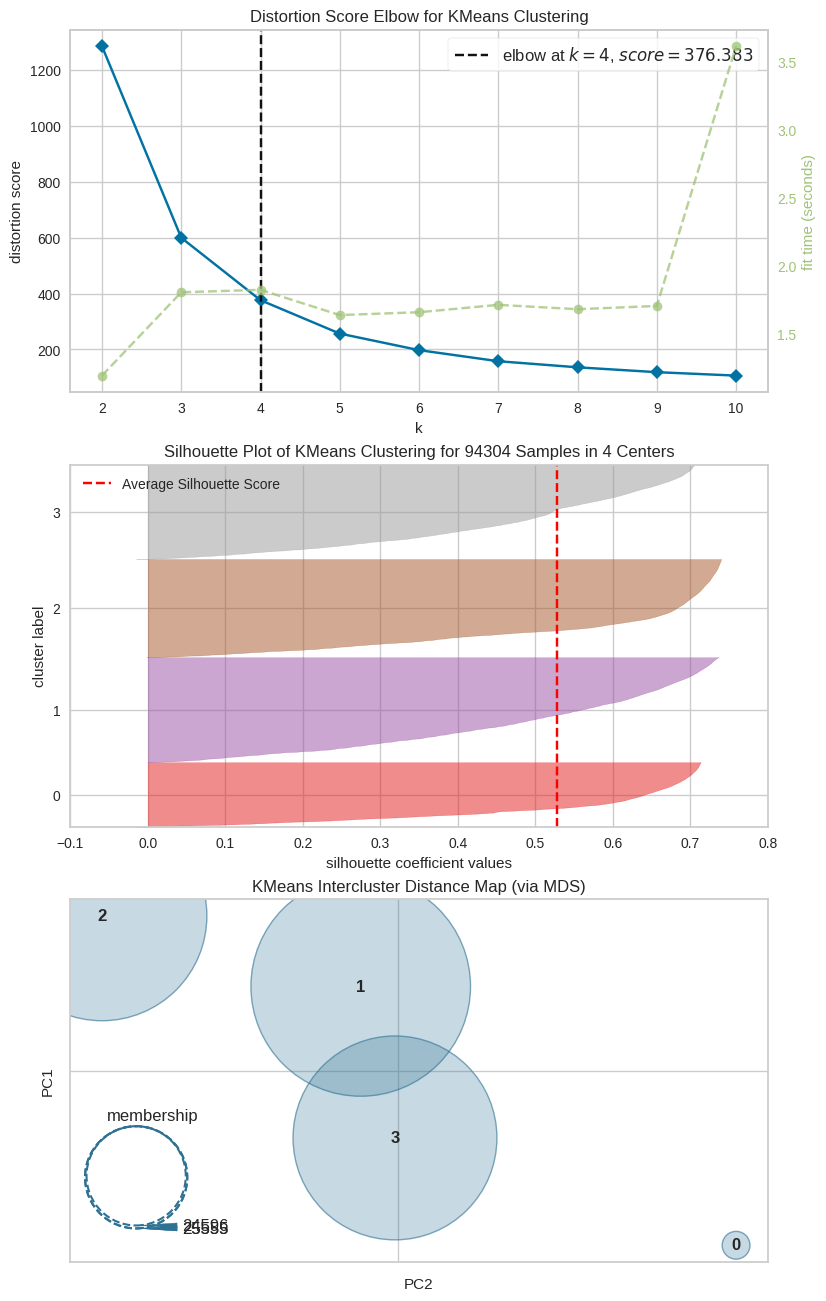

In [71]:
K = evaluate_clusters('rfm') # optimal number of cluster for rfm

In [5]:
def calinski_score(data, sigle_columns, K):
  """
  data as dataframe to evaluate
  ex. of sigle_column : 'rfms'
  K as nb cluster

  """
  model = KMeans(n_clusters=K, random_state=42)
  model.fit(MinMaxScaler().fit_transform(data))
  labels = model.labels_
  data['label'] = labels

  print(f'calinski score = {round(calinski_harabasz_score(data, labels),2)} for {sigle_columns} evaluation')

In [73]:
calinski_score(RFM_df_numeric[dict_features['rfm']].copy(), 'rfm', 4)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


calinski score = 12725.61 for rfm evaluation


In [6]:
def main_cat(x): # compute main frequente value in a group
    return x.mode().iloc[0]

def compute_mean_label_clusters(K, columns, cat_features = None, scale = True, data_bis = None):
  """
  use cat_features as liste of column(s) name(s) -> e.g. cat_features = ['category_numeric']
  use columns as sigle of used features for the model fitting -> e.g. rfmsi
  """
  # sclaing if necessary
  if data_bis is not None:
    data = data_bis
  elif data_bis is None:
    data = RFM_df_numeric.copy()[columns]

  if scale == True:
    data_scaled = MinMaxScaler().fit_transform(data)
  else:
    data_scaled = data

  model = KMeans(n_clusters=K, random_state=42)

  start_time = time()
  model.fit(data_scaled)
  end_time = time()
  timing_kmean = f'KMeans computed in {round(end_time - start_time)} sec.'

  labels = model.labels_

  data['label'] = labels

  if cat_features is not None:
    # Create a dictionary to specify aggregation functions for each column
    aggregation_dict = {col: 'mean' for col in data.drop('label', axis=1).columns if col not in cat_features}
    aggregation_dict.update({col: main_cat for col in cat_features})
  else:
    aggregation_dict = {col: 'mean' for col in data.drop('label', axis=1).columns}

  # Group by 'label' and apply aggregation functions
  data_cluster = data.groupby('label').agg(aggregation_dict)

  display(timing_kmean, data['label'].value_counts(normalize=True).sort_values(ascending=False))

  return(data_cluster)

In [7]:
# create a copmplexradar plot
def complex_radar_plot(data, convert_to_df=True):
  """
  data as dataframe of cluster means per feature
  """
  # Create a sample DataFrame

  #data = data_cluster
  if convert_to_df==True:
    data_df = pd.DataFrame(data)
  else:
    data_df=data

  # compute general min max distance in features for scaling radar plot
  dict_max = {col:[np.max(data_df[col])] for col in data_df.columns}

  # scaling the data for the radar plot
  df = data_df/pd.DataFrame(dict_max).values
  clust_label = data_df.index

  # Extract column names and values
  column_names = df.columns
  values = df.values  # scaled values used in the radar plot for the lines
  ini_values = data_df.values # initial values in their original scale which will appear as text in radar plot for revealing lines values

  # Number of variables (columns)
  num_vars = len(column_names)

  # Compute angle for each axis
  angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

  # The plot is circular, so we need to "complete the loop" and append the start value to the end.
  # Concatenate the new column to the right
  values = np.concatenate((values, np.expand_dims(values[:,0], axis=1)), axis=1)
  angles += [angles[0]]

  # Create subplots
  fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

  # Draw one axe per variable and add labels
  plt.xticks(angles[0:-1], column_names)
  for clst in range(len(clust_label)):
    ax.fill(angles, values[clst,:], color='C'+ str(clst), alpha=0.25)
    ax.plot(angles, values[clst,:], color='C'+ str(clst), linewidth=2, label=clust_label[clst])

  # add original features values on each feature direction in radar plot at each increment (in range (5))
  for i in range(0, len(angles)-1):
      feature_increment = np.linspace(0, 1, 10)
      ini_feature_increment = np.linspace(0, dict_max[column_names[i]], 10)
      for j in range(len(feature_increment)):
        ax.text(angles[i], feature_increment[j], round(ini_feature_increment[j][0], 1), color='blue', fontsize=7, ha='center', va='center')


  # Add legend
  plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

  # Add title
  plt.title('Radar Plot of Column Values', fontsize=16, fontweight='bold')

  plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'KMeans computed in 2 sec.'

1    0.289903
2    0.270985
3    0.260816
0    0.178296
Name: label, dtype: float64

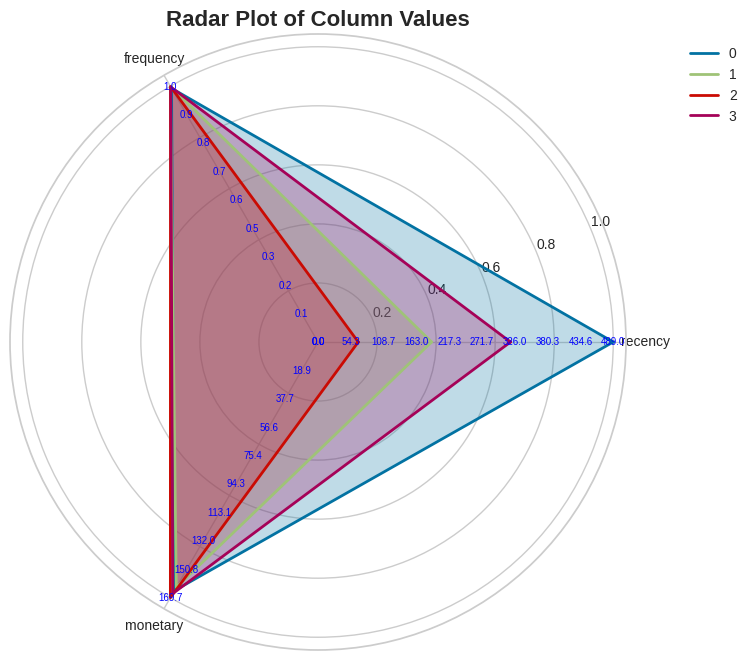

In [76]:
data_cluster = compute_mean_label_clusters(K = K, columns = dict_features['rfm'])

complex_radar_plot(data_cluster)

Cette première segmentation distingue 4 groupes principalement sur la récence des commandes et cela avec un très bon score de silhouette (très fiable pour l'évaluation de clusters) supérieur à 0.5. Les populations des clusters sont bien réparties et à priori bien séparé selon les composantes principales du calcul de distance intercluster.

Avant de continuer, voyons si l'on obtient de bon résultats en normalisant avec un StandardScaler au lieu d'un MinMaxScaler :

In [77]:
# sclaing if necessary

columns = dict_features['rfm']

data = RFM_df_numeric.copy()[columns]

columns_to_minmax_scale = []
columns_to_standard_scale = ['recency', 'frequency', 'monetary']

preprocessor = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), columns_to_minmax_scale),
        ('standard', StandardScaler(), columns_to_standard_scale)
    ]
)


data_scaled = preprocessor.fit_transform(data)

model = KMeans(n_clusters=4, random_state=42)

start_time = time()
model.fit(data_scaled)
end_time = time()
timing_kmean = f'KMeans computed in {round(end_time - start_time)} sec.'

labels = model.labels_

data['label'] = labels

aggregation_dict = {col: 'mean' for col in data.drop('label', axis=1).columns}

# Group by 'label' and apply aggregation functions
data_cluster = data.groupby('label').agg(aggregation_dict)

display(timing_kmean, data['label'].value_counts(normalize=True).sort_values(ascending=False))

print(data_cluster)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'KMeans computed in 1 sec.'

0    0.542936
3    0.399972
2    0.030518
1    0.026574
Name: label, dtype: float64

          recency  frequency     monetary
label                                    
0      133.027478   1.000000   134.437774
1      244.519582   1.021947  1153.184665
2      228.420242   2.271022   300.225823
3      393.125514   1.000000   133.415536


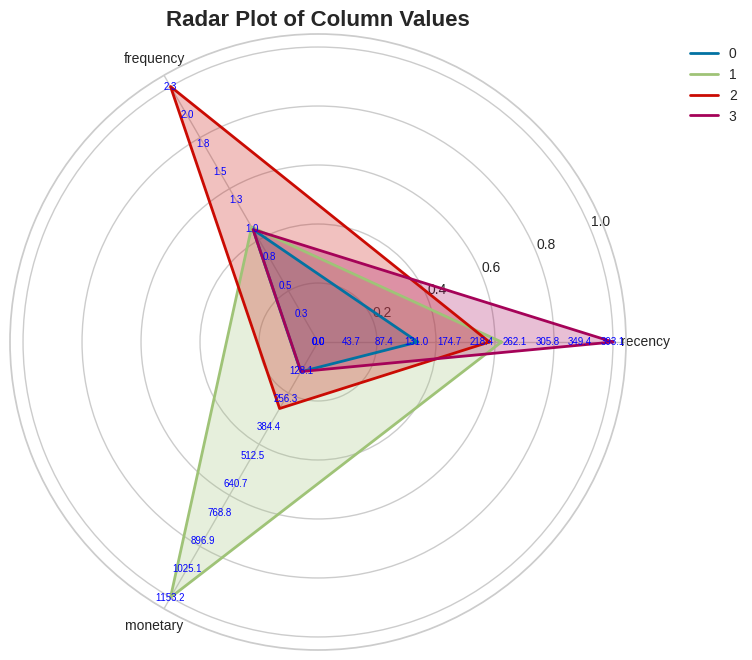

In [78]:
complex_radar_plot(data_cluster)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


SilhouetteVisualizer(ax=<Axes: >,
                     estimator=KMeans(n_clusters=4, random_state=42))

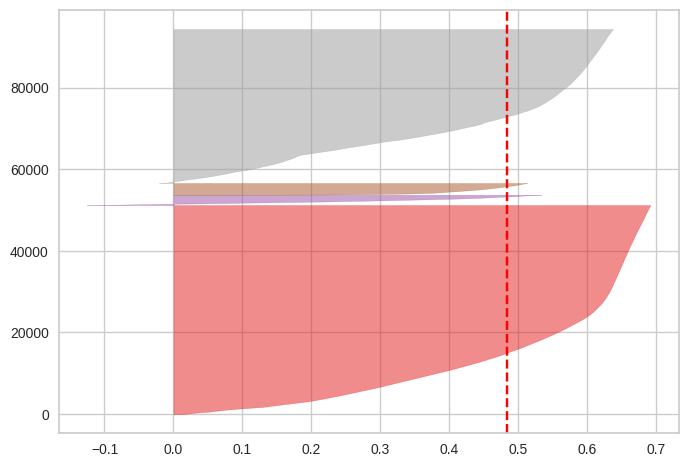

In [79]:
SilhouetteVisualizer(KMeans(n_clusters=4, random_state=42)).fit(data_scaled)

Avec un StandardScaler le score de silhouette moyen est pas mal mais on perd en qualité sur la taille des clusters...

Nous continuerons les essais suivants avec MinMaxScaler.

Testons la segmentaion avec une variable supplémentaire si l'on peut en dégager un interprêtation métier tout en ayant un bon score.

## 4 features : rfms

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

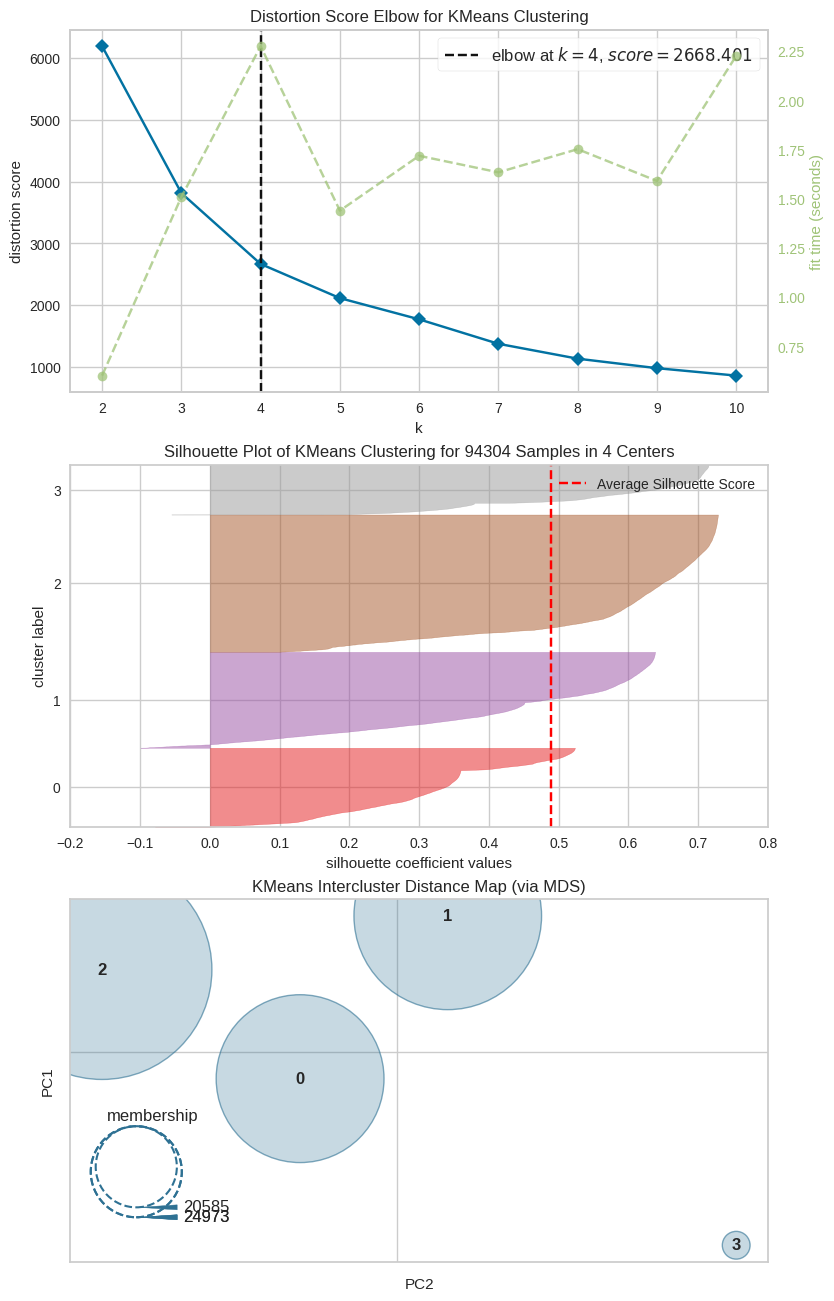

In [80]:
K = evaluate_clusters('rfms') # ajout du review score (satisfaction_mean)

In [81]:
calinski_score(RFM_df_numeric[dict_features['rfms']].copy(), 'rfms', 4)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


calinski score = 6899.97 for rfms evaluation


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'KMeans computed in 1 sec.'

2    0.379157
1    0.264814
0    0.218283
3    0.137746
Name: label, dtype: float64

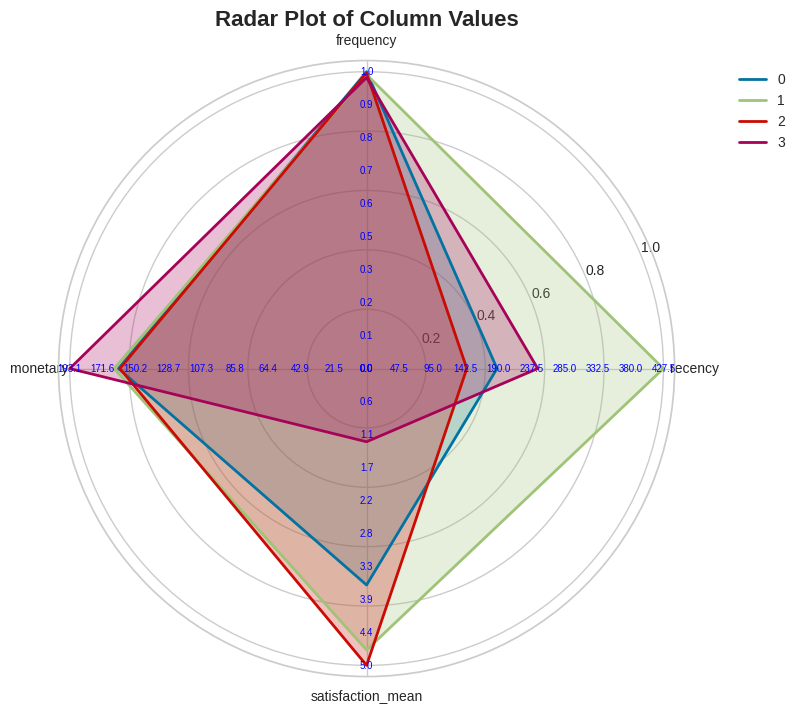

In [82]:
data_cluster = compute_mean_label_clusters(K = K, columns = dict_features['rfms'])
complex_radar_plot(data_cluster)

Nous obtenons une bonne segmentation sur la plupart des variables.

Les clusters sont bien séparés et homogènes.


## 5 features : rfmsi, rfmsd

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

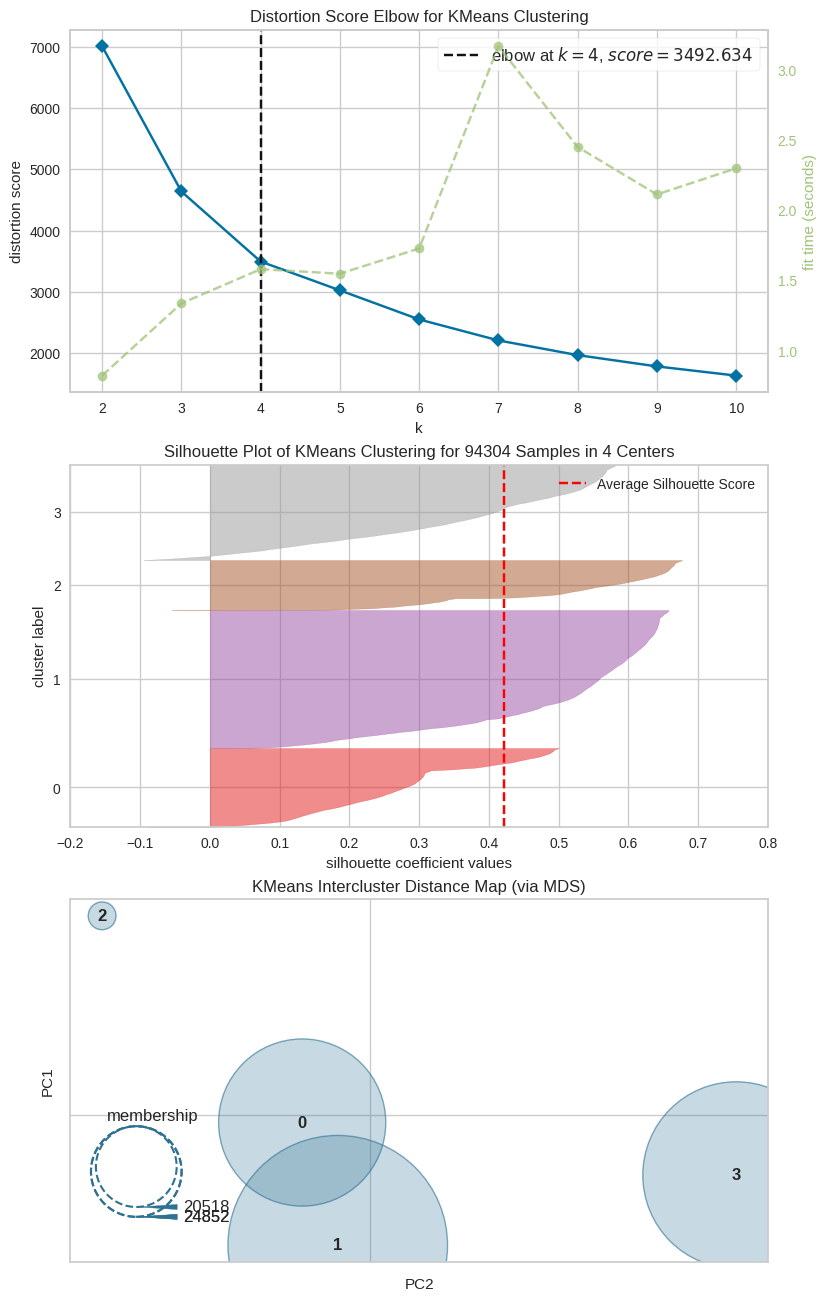

In [83]:
K = evaluate_clusters('rfmsi') # ajout du nombre de paiements par commande (installment_mean)

In [84]:
calinski_score(RFM_df_numeric[dict_features['rfmsi']].copy(), 'rfmsi', 4)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


calinski score = 6925.38 for rfmsi evaluation


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'KMeans computed in 2 sec.'

1    0.381161
3    0.263531
0    0.217573
2    0.137735
Name: label, dtype: float64

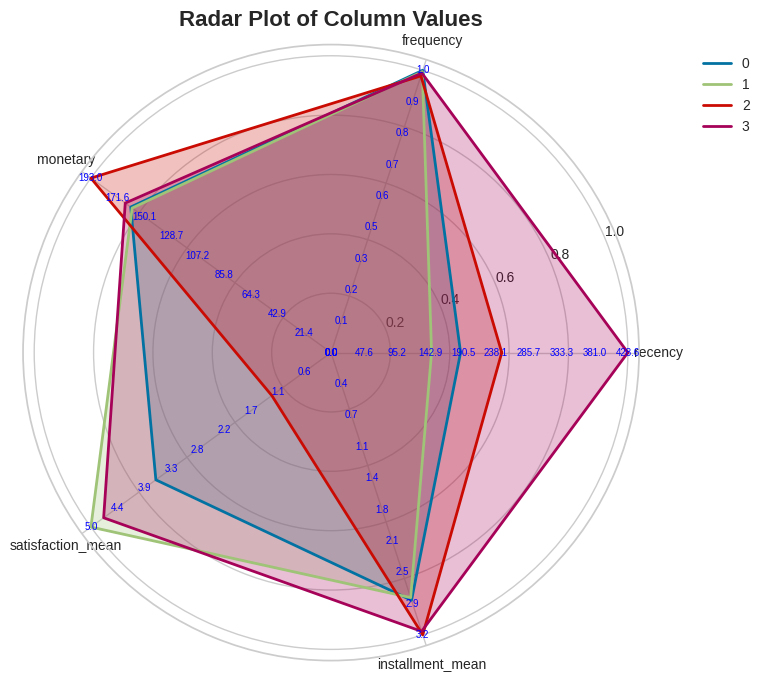

In [85]:
data_cluster = compute_mean_label_clusters(K = K, columns = dict_features['rfmsi'])
complex_radar_plot(data_cluster)

Avec l'installments_mean le score passe à 0.4 mais il y a une segmentation intéressante.

---



Avec la distance client - vendeur :

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

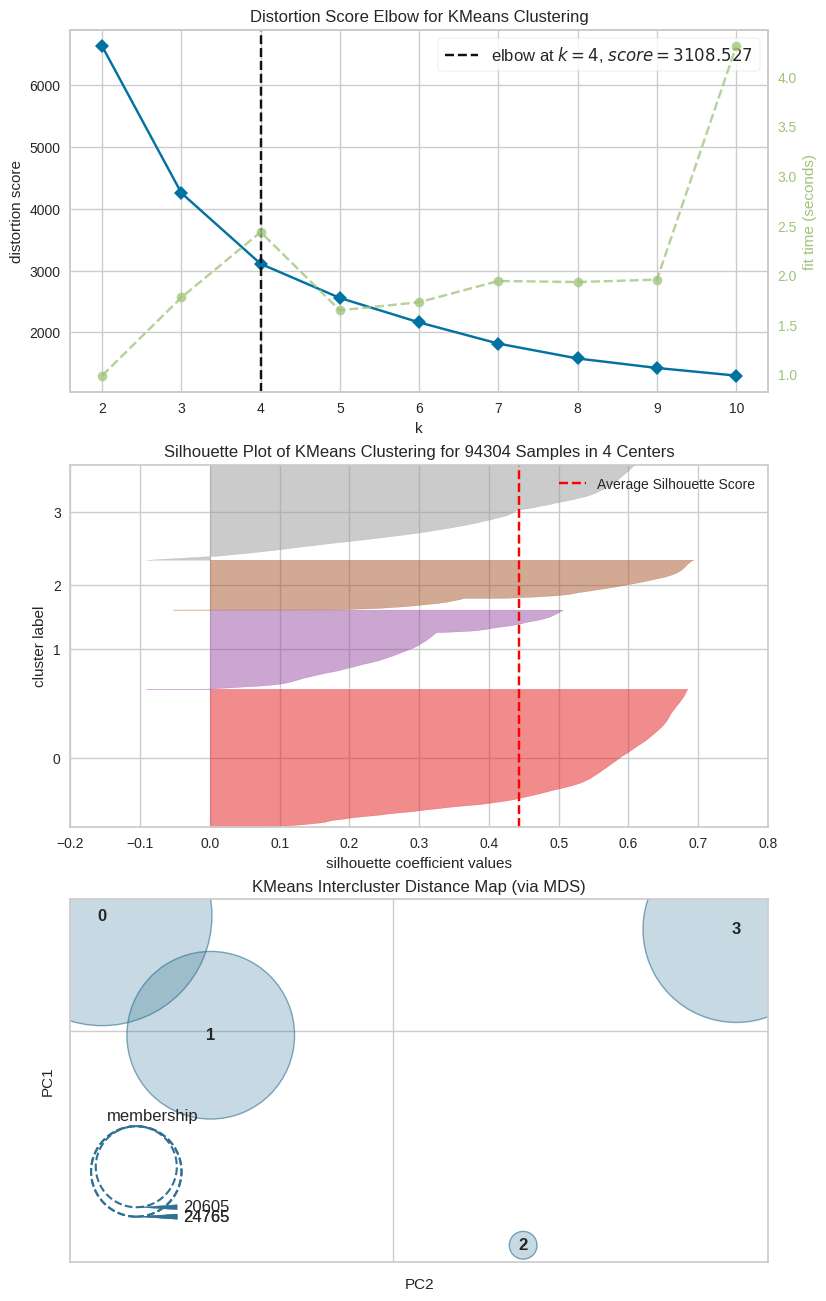

In [86]:
K = evaluate_clusters('rfmsd') # ajout de la distance moyenne client/vendeur

In [87]:
calinski_score(RFM_df_numeric[dict_features['rfmsd']].copy(), 'rfmsd', 5)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


calinski score = 961.8 for rfmsd evaluation


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'KMeans computed in 1 sec.'

0    0.381161
3    0.262608
1    0.218496
2    0.137735
Name: label, dtype: float64

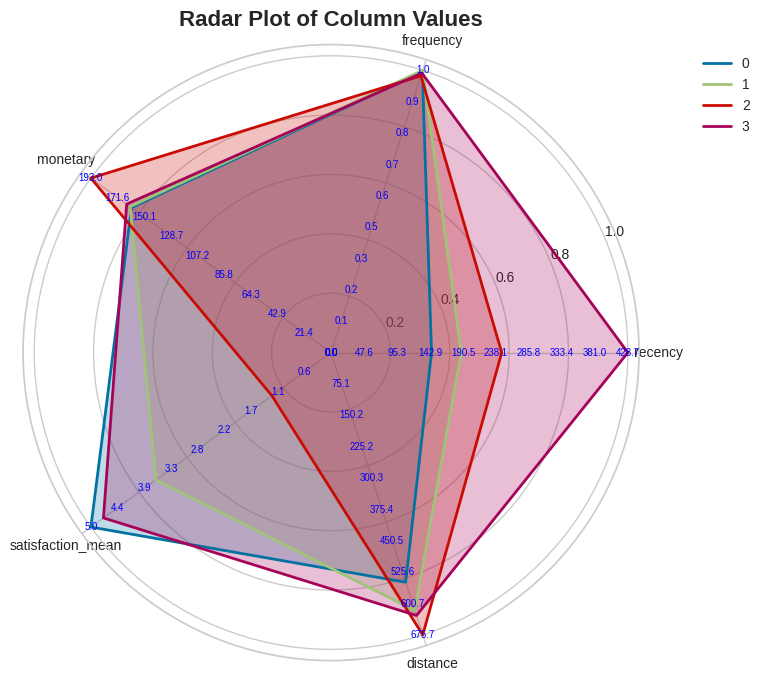

In [88]:
data_cluster = compute_mean_label_clusters(K = K, columns = dict_features['rfmsd'])
complex_radar_plot(data_cluster)

Avec la distance le score moyen est meilleur, au dessus de 0.4.

## 6 features : rfmsdi

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

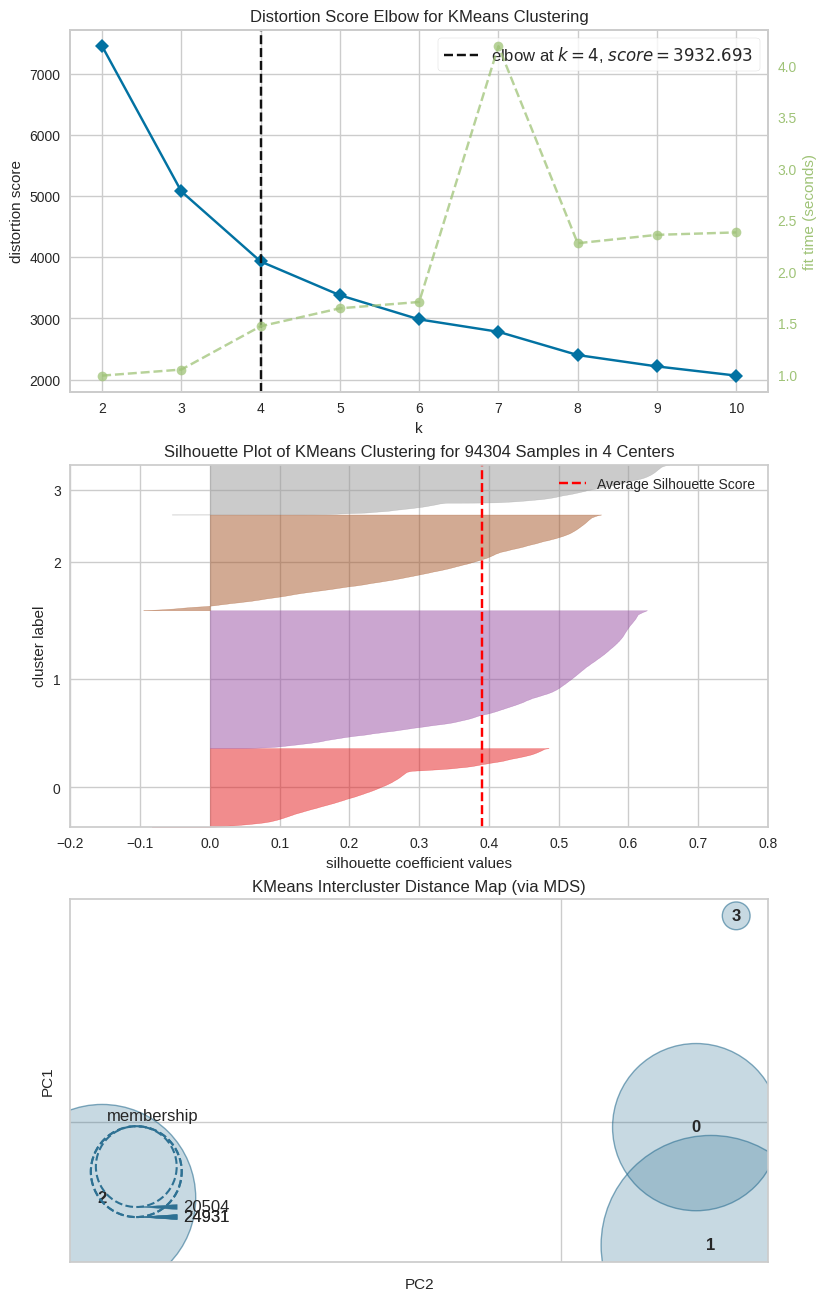

In [89]:
K = evaluate_clusters('rfmsdi') # avec distance et installments_mean

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'KMeans computed in 2 sec.'

1    0.380461
2    0.264368
0    0.217424
3    0.137746
Name: label, dtype: float64

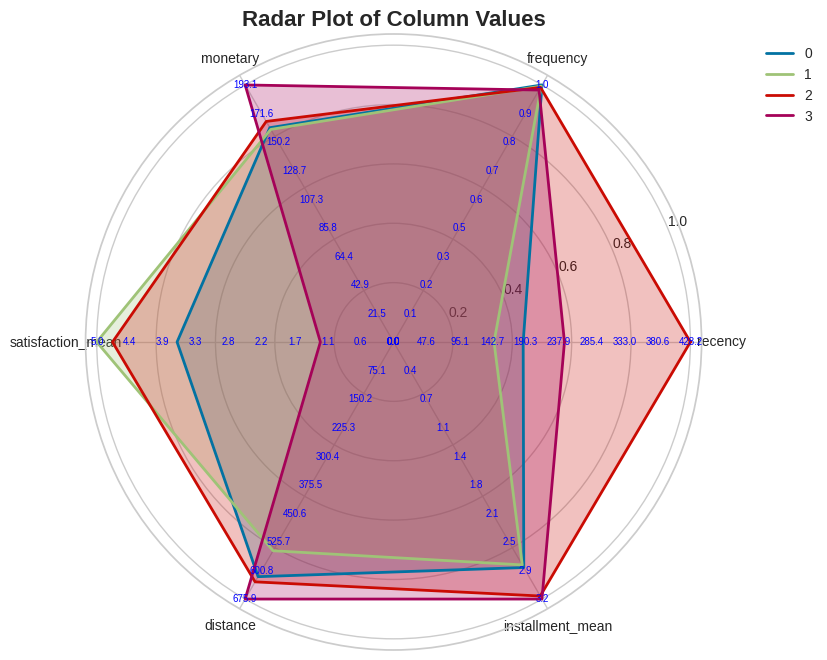

In [90]:
data_cluster = compute_mean_label_clusters(K = 4, columns = dict_features['rfmsdi'])
complex_radar_plot(data_cluster)

Score en dessous de 0.4 mais segmentation intéressante, principalement sur la satisfction et la récence.

## 7 features : rfmsdic, rfmsdis

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

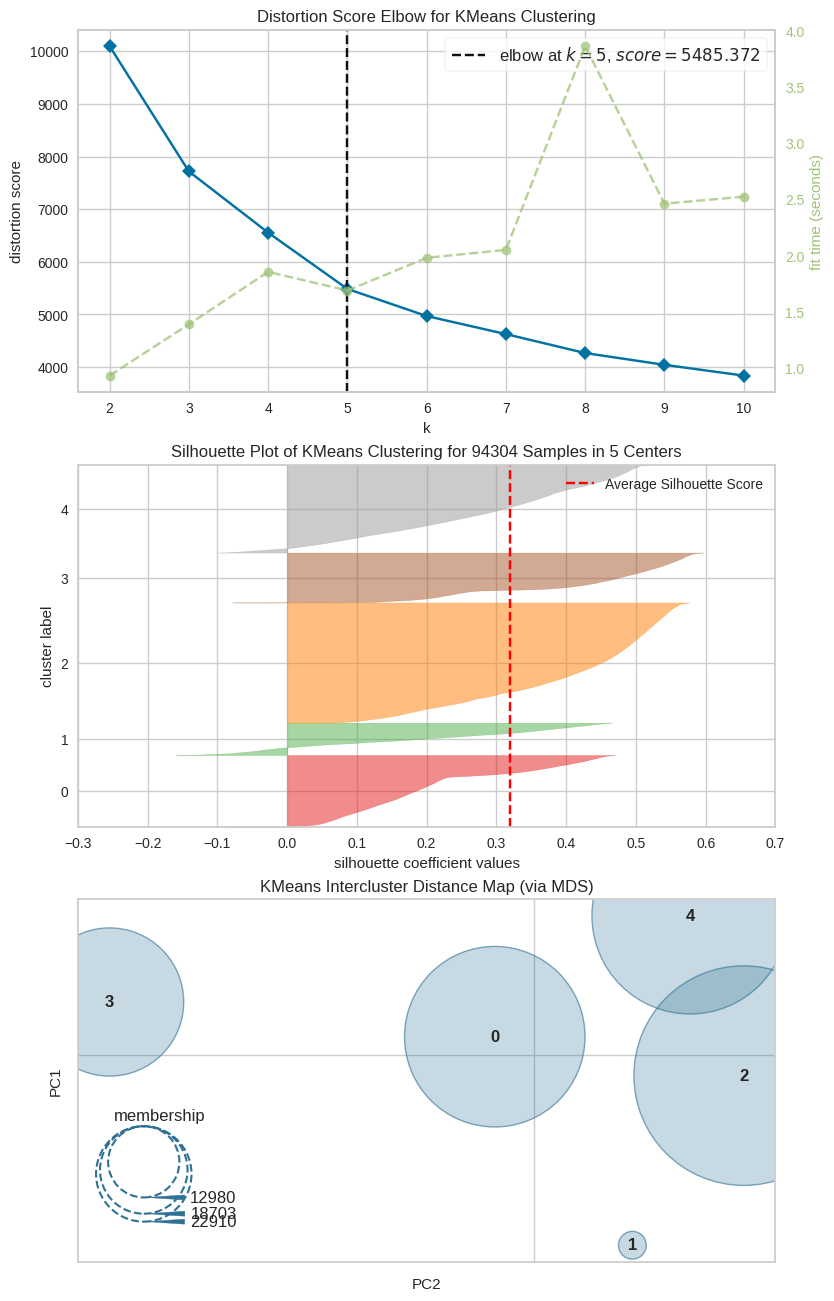

In [91]:
K = evaluate_clusters('rfmsdic') # ajout des catégories d'achat

In [92]:
calinski_score(RFM_df_numeric[dict_features['rfmsdic']].copy(), 'rfmsdic', 5)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


calinski score = 843.82 for rfmsdic evaluation


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'KMeans computed in 3 sec.'

2    0.331852
4    0.242938
0    0.198327
3    0.137640
1    0.089243
Name: label, dtype: float64

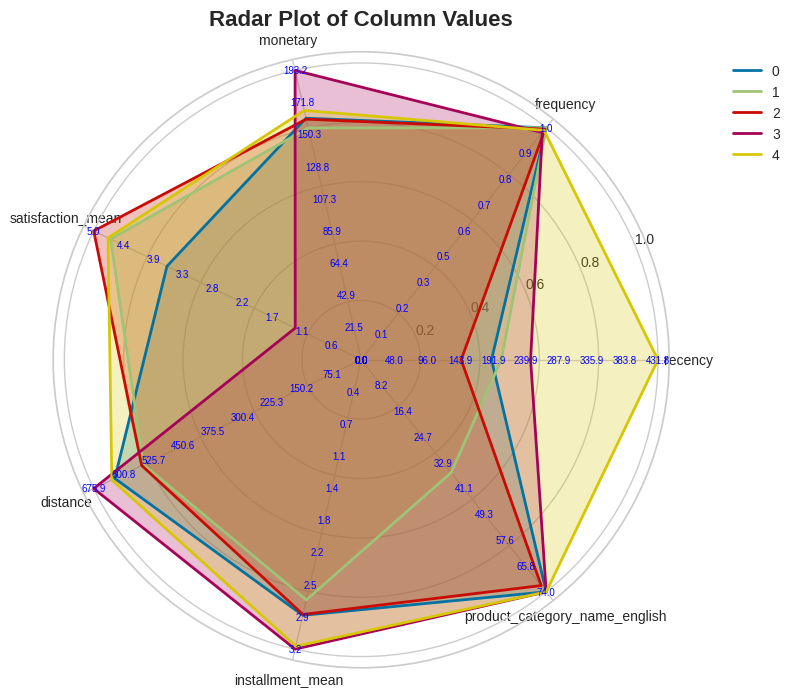

In [94]:
data_cluster = compute_mean_label_clusters(K = K, columns = dict_features['rfmsdic'], cat_features = ['product_category_name_english'])
complex_radar_plot(data_cluster)

Le score est au dessus de 0.3 mais il y a pas mal d'erreurs sur le groupe n°1 qui est d'ailleurs en décalage sur sa population par rapport aux autres groupes.

---



Essai avec l'Etat du client :

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

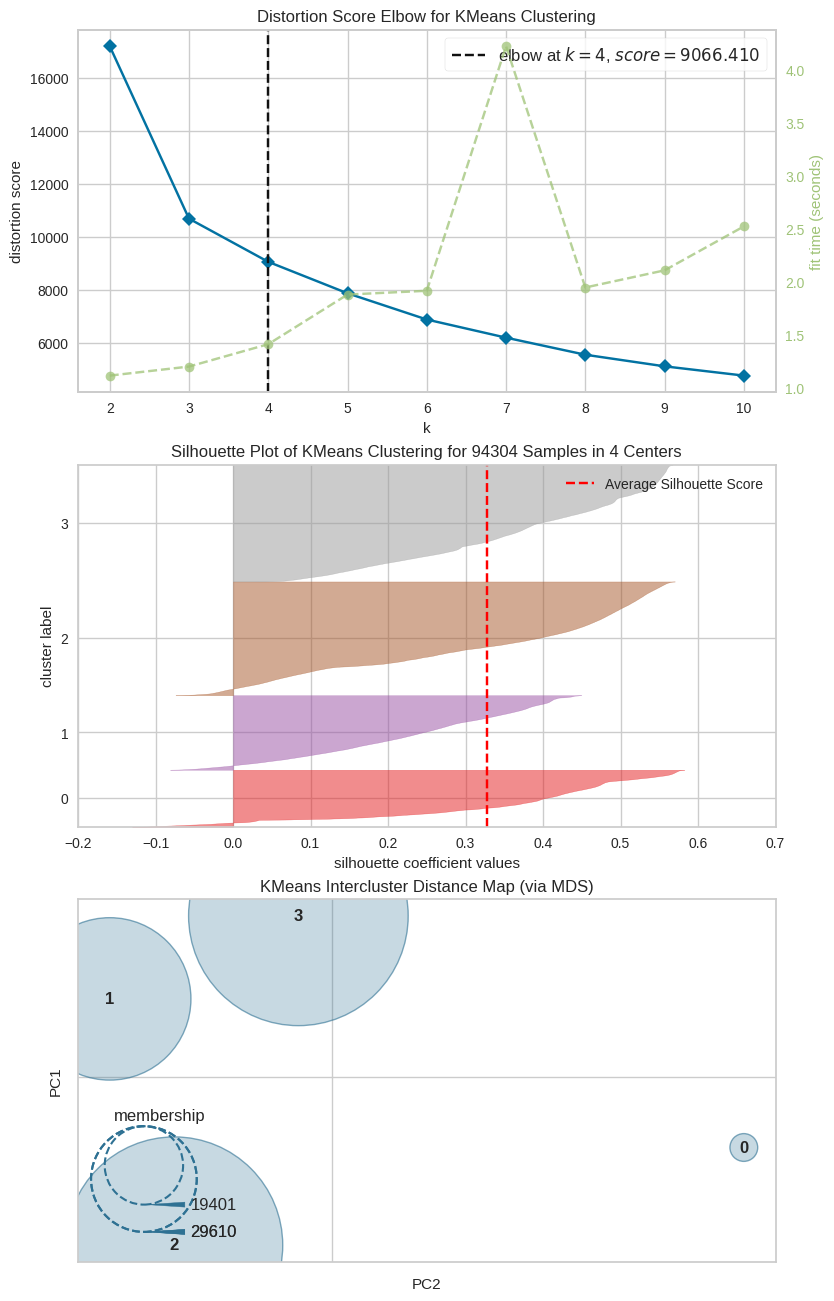

In [95]:
K = evaluate_clusters('rfmsdis') # avec les états (states)

In [96]:
calinski_score(RFM_df_numeric[dict_features['rfmsdis']].copy(), 'rfmsdis', 4)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


calinski score = 3335.46 for rfmsdis evaluation


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'KMeans computed in 2 sec.'

3    0.322606
2    0.313985
1    0.205728
0    0.157682
Name: label, dtype: float64

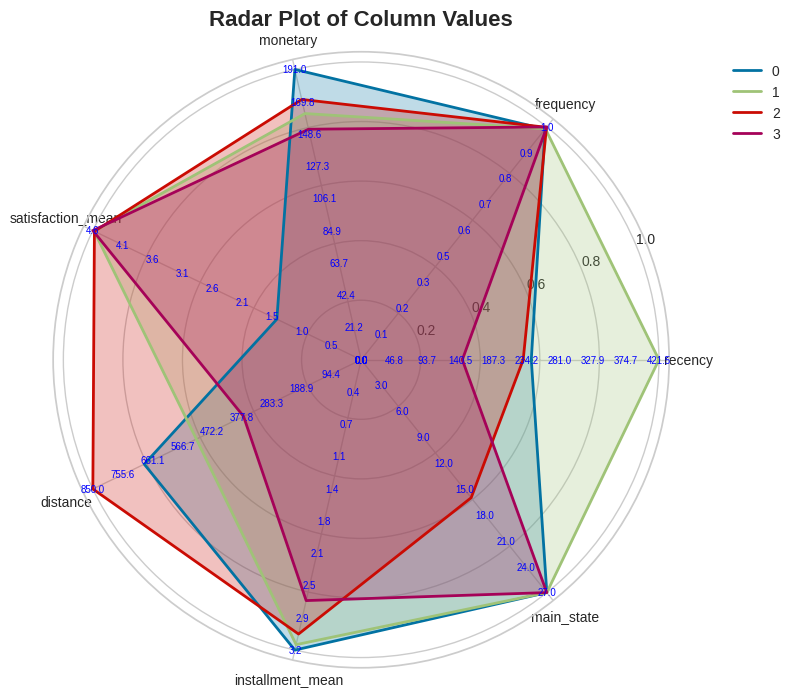

In [97]:
data_cluster = compute_mean_label_clusters(K = K, columns = dict_features['rfmsdis'], cat_features = ['main_state'])
complex_radar_plot(data_cluster)

Ce groupement est meilleur que le précédent car avec le même score celui-ci est plus homogène et ses groupes sont bien séparés.

Les groupes se distiguent beaucoup sur les caractéristiques de distance et de récence.

Nous pouvons aussi observer la présence d'une groupe commandant depuis une région éloigné et un second qui est globalement peu satisfait.

## 8 features : rfmsdics

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

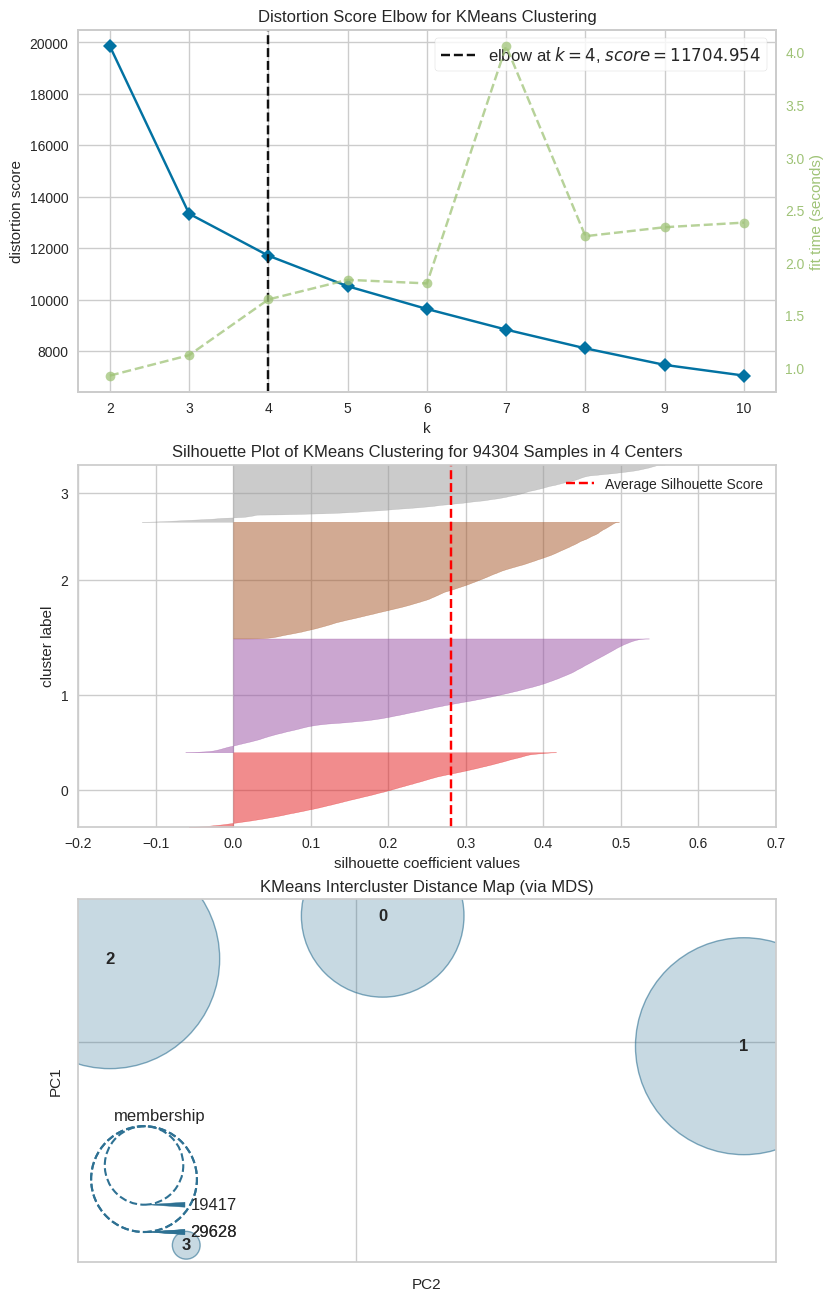

In [98]:
K = evaluate_clusters('rfmsdics') # avec state et category

In [99]:
calinski_score(RFM_df_numeric[dict_features['rfmsdics']].copy(), 'rfmsdics', 5)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


calinski score = 3338.19 for rfmsdics evaluation


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'KMeans computed in 3 sec.'

2    0.322128
1    0.314175
0    0.205898
3    0.157798
Name: label, dtype: float64

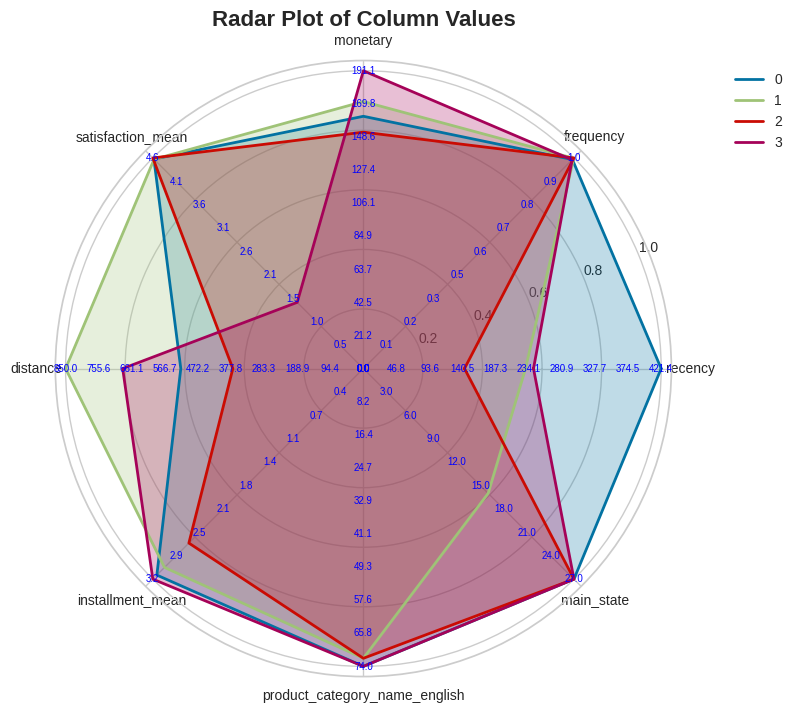

In [100]:
data_cluster = compute_mean_label_clusters(K = K, columns = dict_features['rfmsdics'], cat_features = ['product_category_name_english', 'main_state'])
complex_radar_plot(data_cluster)

Le score diminue et l'ajout des catégories de produit complexifie inutilement la lecture du graphique. Ces dernières ne permettent pas de faire de distinction particulière entre les groupes.

Nous allons tester d'autres ensembles de 5 à 7 caractèristiques.

## Réévaluation de rfmsi avec state et category

La segmentation rfmsi (cf. dictionnaire en amont) est un bon rapport entre un bon coefficient de silhouette (légèrement inférieur à 0.4) et un grand nombre de caractéristiques.

Voyons si nous obtenons des résultats acceptables en ajoutant les catégories d'achats et d'états.

In [123]:
# on recrée le dictionnaire
dict_features = {
    'rfmsic' : ['recency', 'frequency', 'monetary', 'satisfaction_mean', 'installment_mean', 'product_category_name_english'],
    'rfmsis' : ['recency', 'frequency', 'monetary', 'satisfaction_mean', 'installment_mean', 'main_state'],
    'rfmsics' : ['recency', 'frequency', 'monetary', 'satisfaction_mean', 'installment_mean', 'product_category_name_english', 'main_state']
}

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

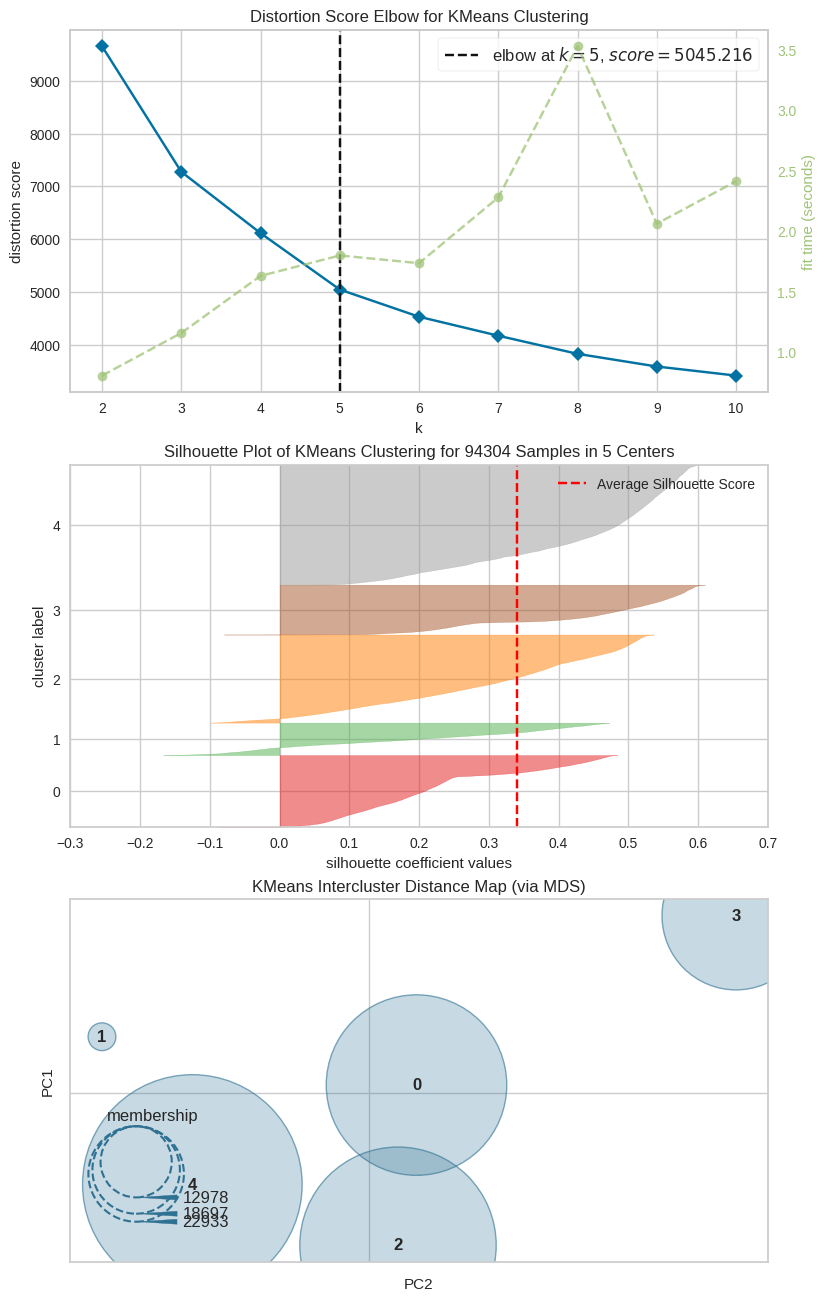

In [102]:
K1 = evaluate_clusters('rfmsic') # avec installement et category

In [103]:
calinski_score(RFM_df_numeric[dict_features['rfmsic']].copy(), 'rfmsic', 4)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


calinski score = 6702.65 for rfmsic evaluation


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'KMeans computed in 3 sec.'

4    0.331524
2    0.243182
0    0.198263
3    0.137619
1    0.089413
Name: label, dtype: float64

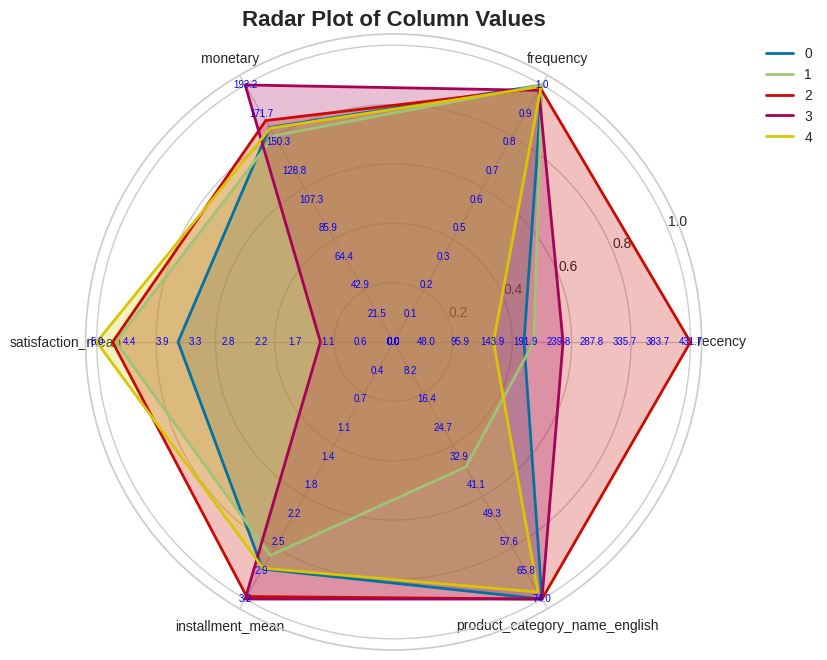

In [104]:
data_cluster1 = compute_mean_label_clusters(K = K1, columns = dict_features['rfmsic'], cat_features = ['product_category_name_english'])
complex_radar_plot(data_cluster1)

Bien que le score soit supérieur à 0.3 le groupe 1 n'est pas équilibré et a quelques erreurs.

---



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

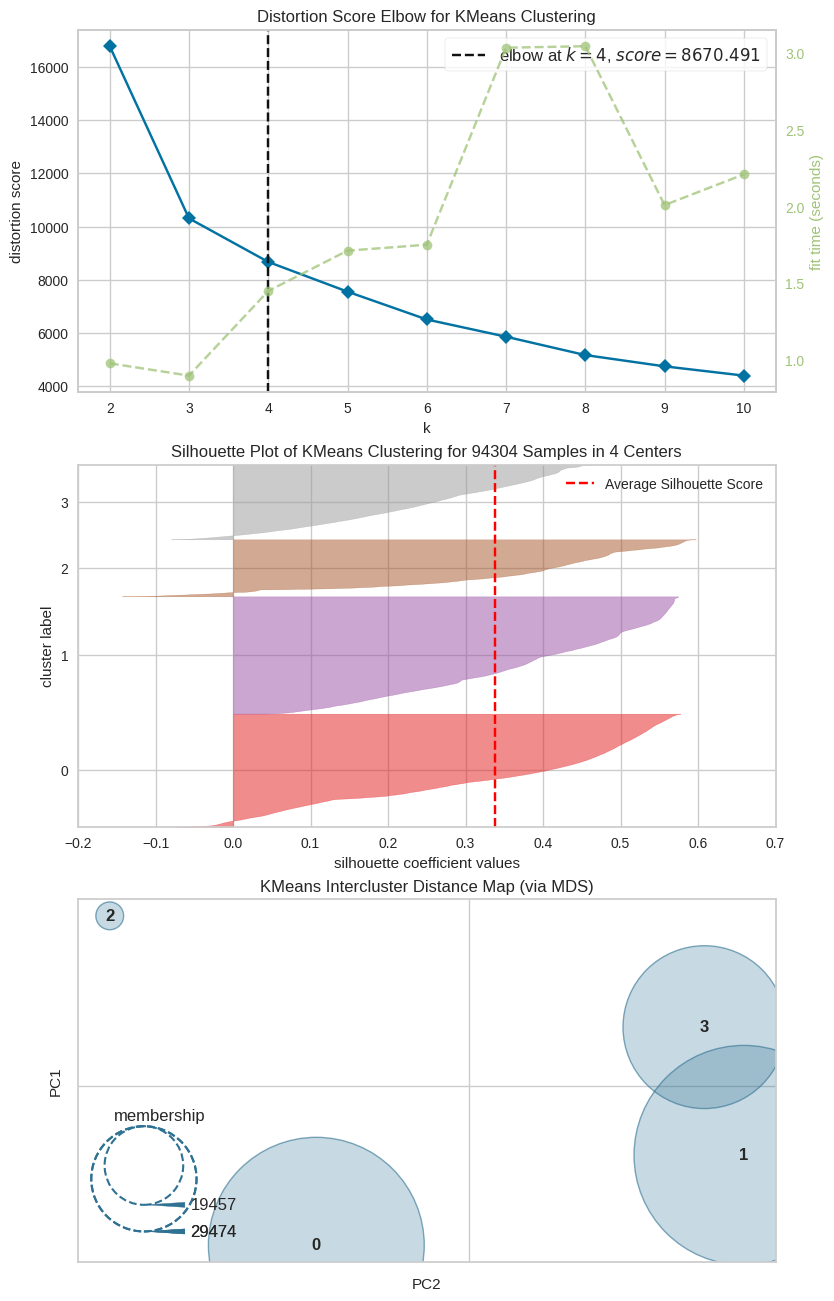

In [105]:
K2 = evaluate_clusters('rfmsis') # installement et state

In [ ]:
calinski_score(RFM_df_numeric[dict_features['rfmsis']].copy(), 'rfmsis', 4)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'KMeans computed in 2 sec.'

1    0.323846
0    0.312542
3    0.206322
2    0.157289
Name: label, dtype: float64

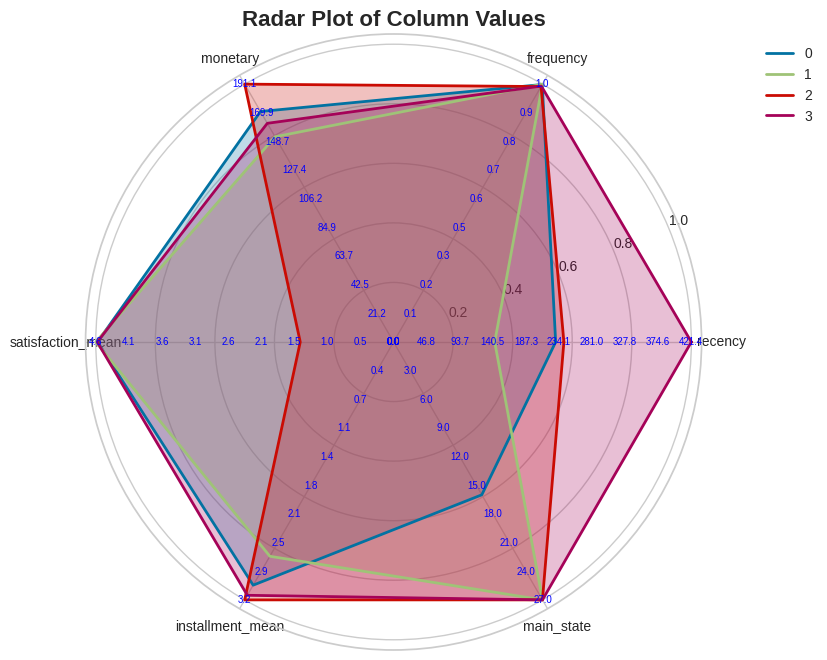

In [124]:
data_cluster2 = compute_mean_label_clusters(K = K2, columns = dict_features['rfmsis'], cat_features = ['main_state'])
complex_radar_plot(data_cluster2)

Score au dessus de 0.3 mais les clusters sont moins bien séparés.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

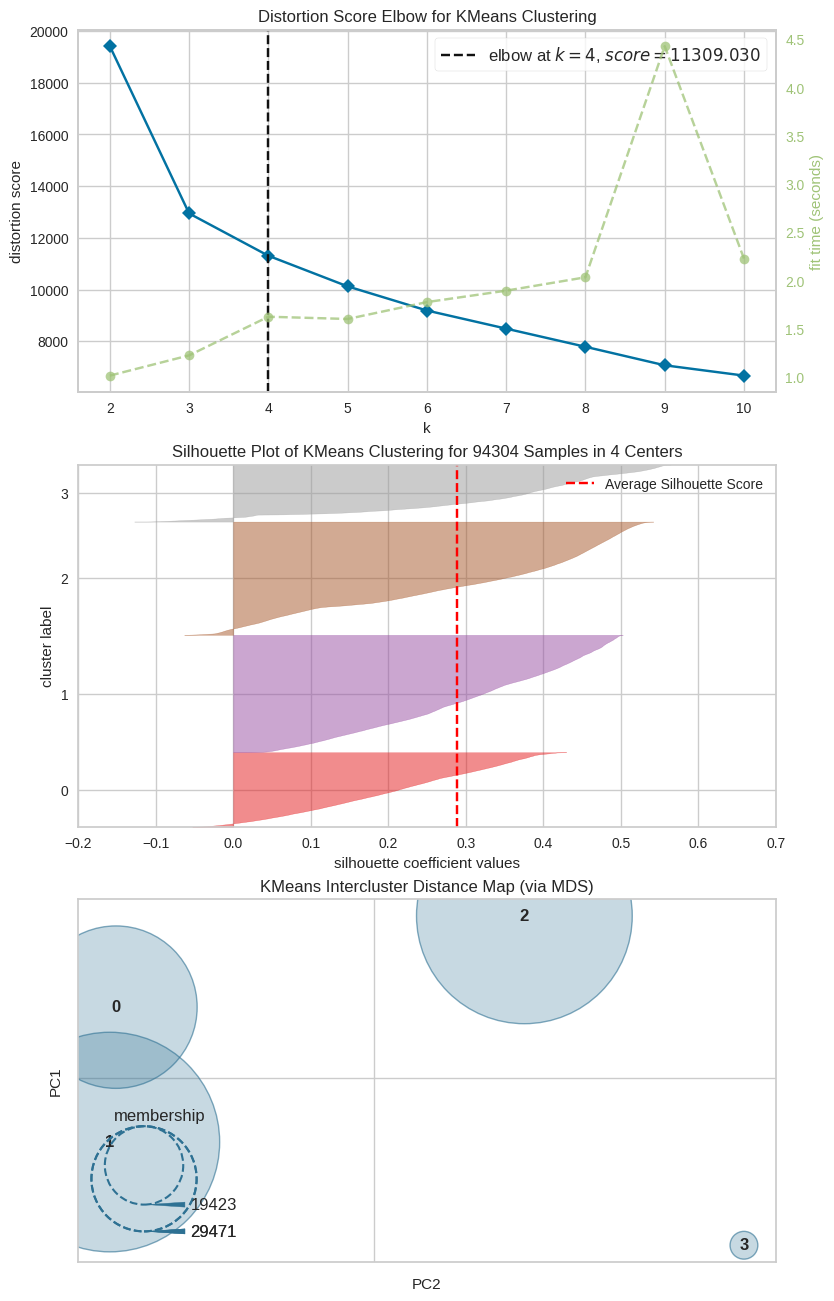

In [125]:
K3 = evaluate_clusters('rfmsics') # installment avec category et state

In [106]:
calinski_score(RFM_df_numeric[dict_features['rfmsics']].copy(), 'rfmsics', 4)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


calinski score = 4867.17 for rfmsics evaluation


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'KMeans computed in 3 sec.'

1    0.324164
2    0.312511
0    0.205962
3    0.157363
Name: label, dtype: float64

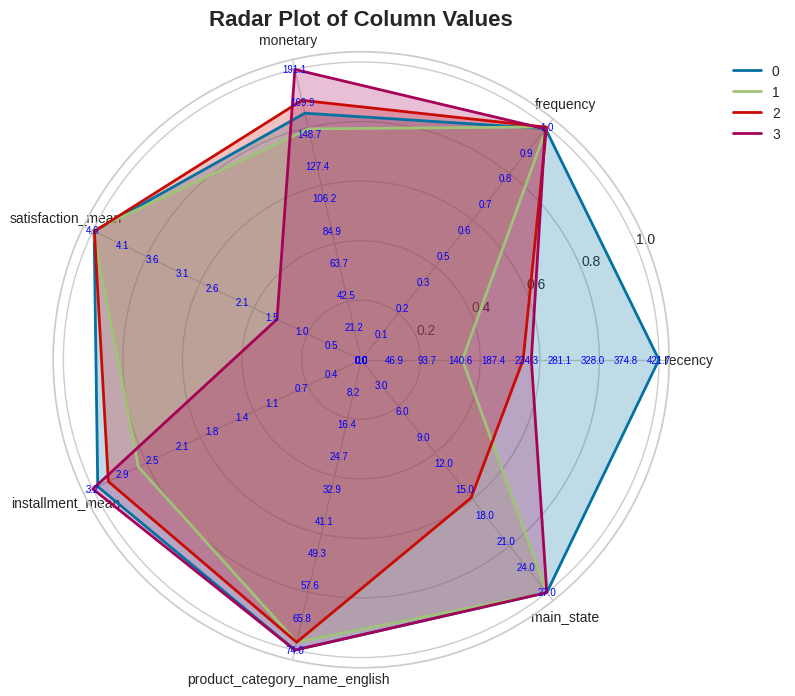

In [122]:
data_cluster3 = compute_mean_label_clusters(K = K3, columns = dict_features['rfmsics'], cat_features = ['product_category_name_english', 'main_state'])
complex_radar_plot(data_cluster3)

In [107]:
compute_mean_label_clusters(K = K3, columns = dict_features['rfmsics'], cat_features = ['product_category_name_english', 'main_state'])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'KMeans computed in 2 sec.'

1    0.324164
2    0.312511
0    0.205962
3    0.157363
Name: label, dtype: float64

recency  frequency    monetary  satisfaction_mean  installment_mean  \
label                                                                           
0      421.678509   1.035267  162.319832           4.605022          3.154203   
1      143.332856   1.042623  151.997184           4.626706          2.666931   
2      229.409156   1.041532  170.808266           4.599992          3.027443   
3      241.019970   1.033760  191.131895           1.450623          3.212850   

       product_category_name_english  main_state  
label                                             
0                                 74          27  
1                                 72          27  
2                                 72          16  
3                                 74          27

Le score diminu mais encore une fois les catégories de produit ne sont pas pertinents.

## Réévaluation de rfmsd avec state et category

La segmentation rfmsd (cf. dictionnaire en amont) est également un bon rapport entre un bon coefficient de silhouette (légèremrnt au dessus de 0.4) et un grand nombre de caractéristiques.

Voyons si nous obtenons des résultats acceptables en ajoutant les catégories d'achats et d'états.

In [108]:
# on recrée le dictionnaire
dict_features = {
    'rfmsdc' : ['recency', 'frequency', 'monetary', 'satisfaction_mean', 'distance', 'product_category_name_english'],
    'rfmsds' : ['recency', 'frequency', 'monetary', 'satisfaction_mean', 'distance', 'main_state'],
    'rfmsdcs' : ['recency', 'frequency', 'monetary', 'satisfaction_mean', 'distance', 'product_category_name_english', 'main_state']
}

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

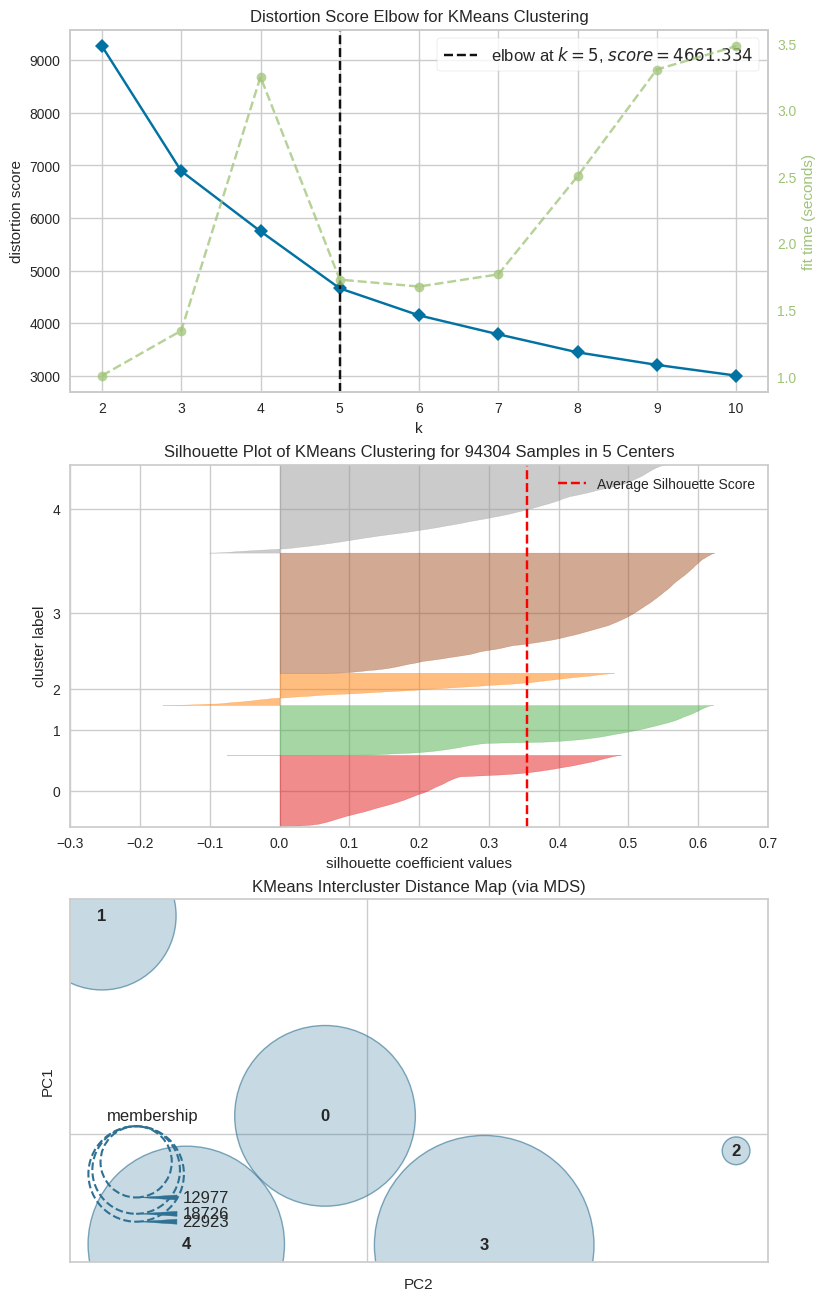

In [109]:
K1 = evaluate_clusters('rfmsdc') # distance et category

In [110]:
calinski_score(RFM_df_numeric[dict_features['rfmsdc']].copy(), 'rfmsdc', 5)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


calinski score = 842.38 for rfmsdc evaluation


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'KMeans computed in 2 sec.'

3    0.331545
4    0.243076
0    0.198571
1    0.137608
2    0.089201
Name: label, dtype: float64

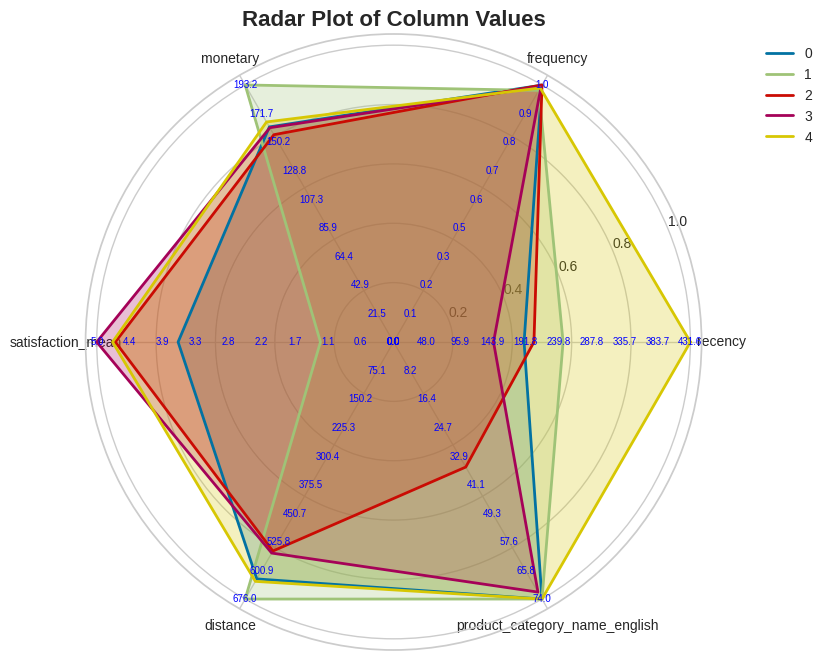

In [111]:
data_cluster1 = compute_mean_label_clusters(K = K1, columns = dict_features['rfmsdc'], cat_features = ['product_category_name_english'])
complex_radar_plot(data_cluster1)

Score au dessus de 0.3 et bien séparés mais l'un des groupes est très petit.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

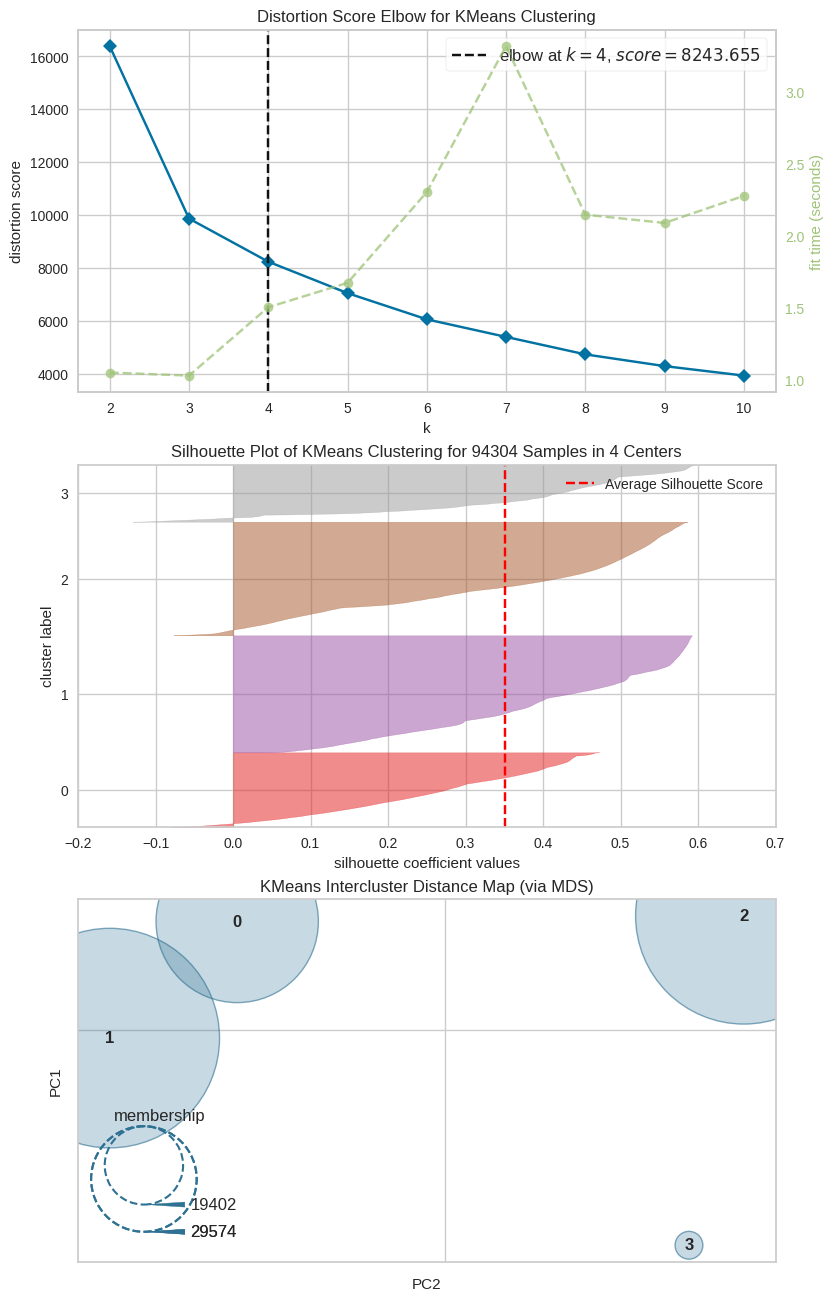

In [112]:
K2 = evaluate_clusters('rfmsds') # distance et state

In [113]:
calinski_score(RFM_df_numeric[dict_features['rfmsds']].copy(), 'rfmsds', 4)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


calinski score = 4040.84 for rfmsds evaluation


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'KMeans computed in 1 sec.'

1    0.322998
2    0.313603
0    0.205739
3    0.157660
Name: label, dtype: float64

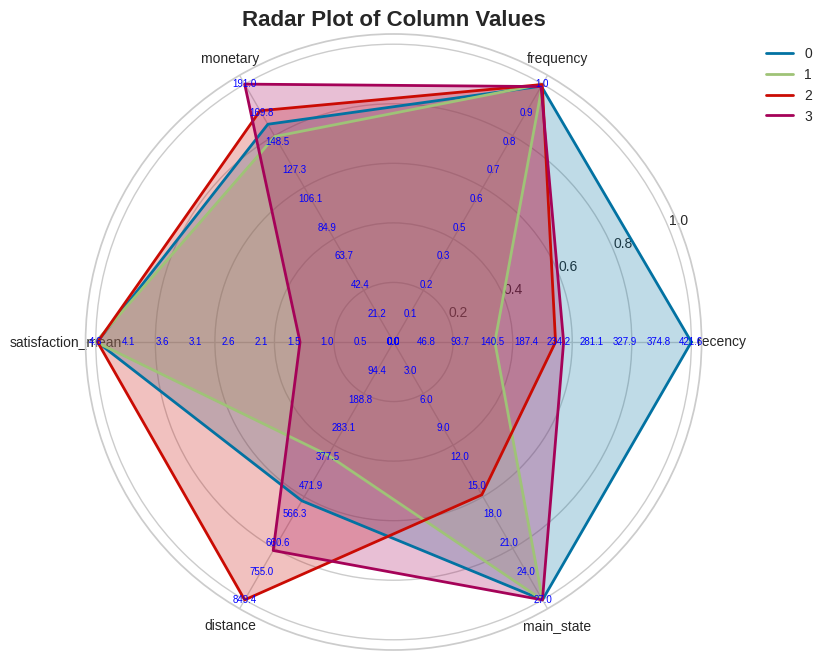

In [114]:
data_cluster2 = compute_mean_label_clusters(K = K2, columns = dict_features['rfmsds'], cat_features = ['main_state'])
complex_radar_plot(data_cluster2)

Score meilleur avec state entre 0.3 et 0.4.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

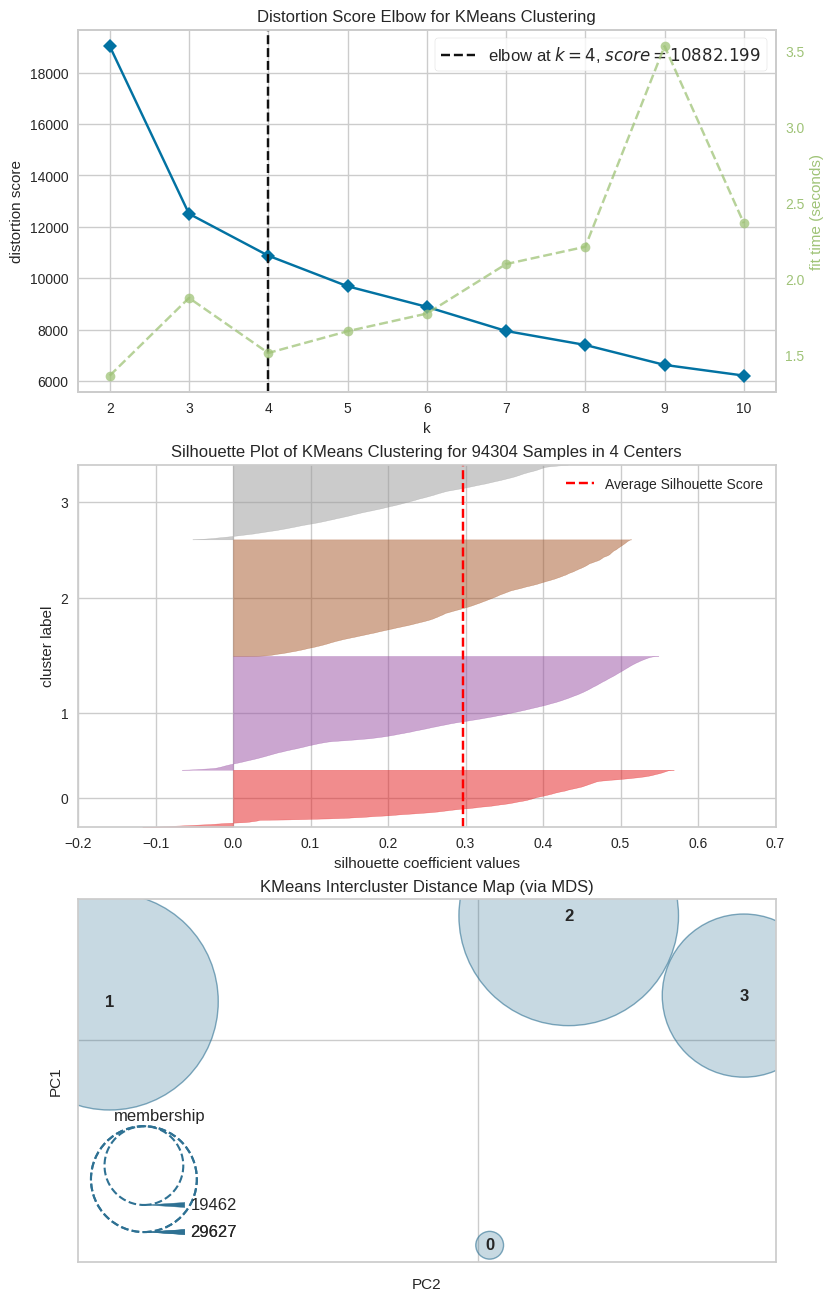

In [115]:
K3 = evaluate_clusters('rfmsdcs') # distance avec category et state

In [116]:
calinski_score(RFM_df_numeric[dict_features['rfmsdcs']].copy(), 'rfmsdcs', 4)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


calinski score = 4045.88 for rfmsdcs evaluation


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'KMeans computed in 1 sec.'

2    0.321768
1    0.314165
3    0.206375
0    0.157692
Name: label, dtype: float64

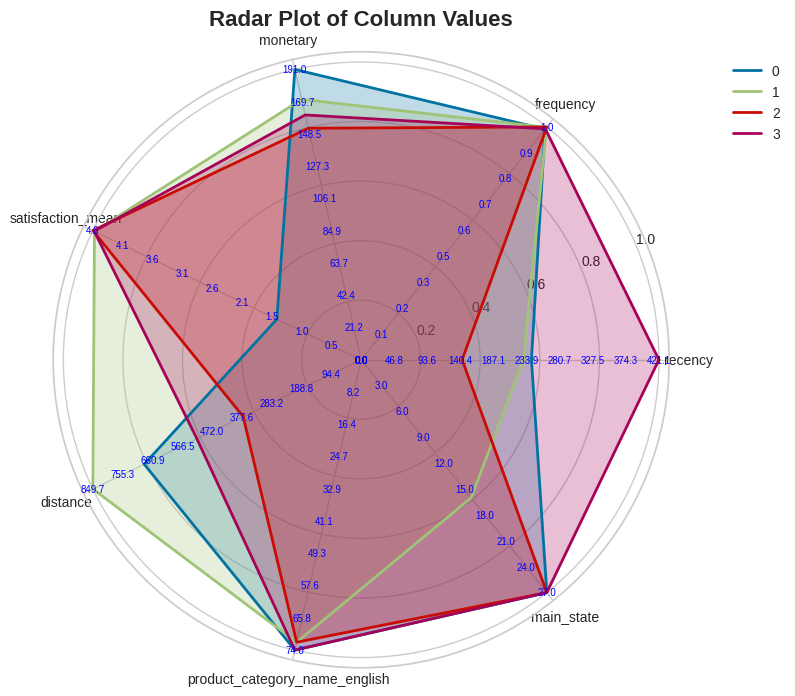

In [117]:
data_cluster3 = compute_mean_label_clusters(K = K3, columns = dict_features['rfmsdcs'], cat_features = ['product_category_name_english', 'main_state'])
complex_radar_plot(data_cluster3)

Score un peu en dessous de 0.3.

# Choix et interprétation métier des clusters

Parmi toutes les combinaisons de features testées pour la segmentation, celle qui selon moi présente le meilleur rapport entre la quantité de caractéristiques et la qualité des segmentations est la combinaison rfmsdis.

Pour rappel voici les caractéristiques :

- recency
- frequency
- monetary
- satisfaction_mean
- distance
- installment_mean
- main_state

En effet, à partir de 7 features utilisées dans l'entraînement, le score de silhouette moyen descend en dessous de 0.3 pour la plupart des modèles testés.

Or, cette combinaison obtient un score moyen très légèrement au dessus de 0.3.

Les caractèristiques permettent de différencier des groupes homogénéisés. En effet, le groupe le moins peuplé concentre au moins 15% des données totales.

Enfin, on peut voir dans la projection sur les deux premières composantes de l'espace interclusters que les groupes sont bien séparés les uns des autres ce qui est un point positif supplémentaire.

Rappel de la segmentation `rfmsdis` :

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'KMeans computed in 2 sec.'

3    0.322606
2    0.313985
1    0.205728
0    0.157682
Name: label, dtype: float64

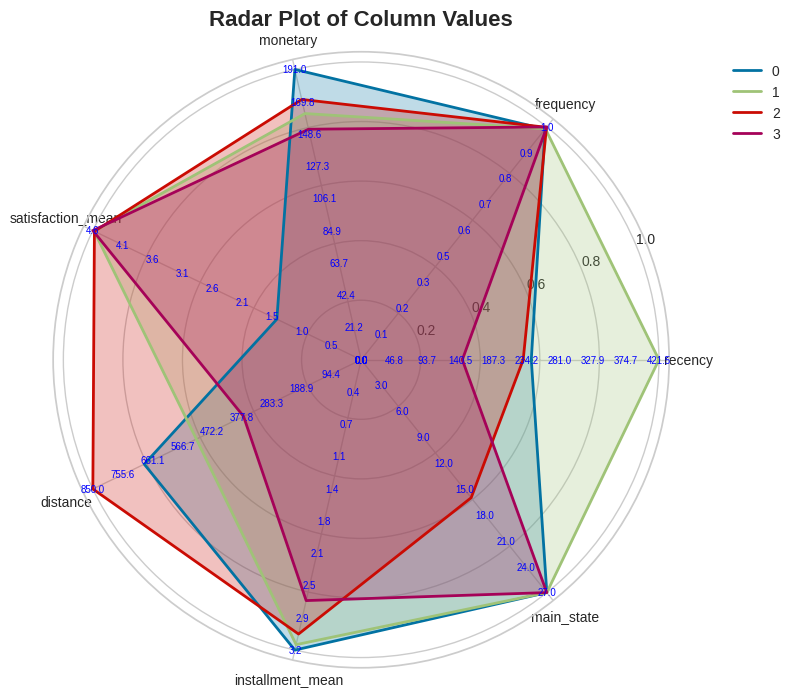

In [128]:
data_cluster = compute_mean_label_clusters(K = 4, columns = dict_features['rfmsdis'], cat_features = ['main_state'])
complex_radar_plot(data_cluster)

Nous pouvons bien distinguer les particularités de chaque groupe  :


**Groupe 0** :
Clients mécontents et éloignés qui payent en plusieurs versements et ont dernièrement commandé il y a longtemps. Ils sont cependant ceux qui dépenses le plus.

**Groupe 1** :
Ces clients n'ont pas commandé depuis très longtemps, ils sont loin des fournisseurs et payent en plusieurs versements. Il sont cependant très satisfait.

**Groupe 2** :
Ces clients commandent principalement depuis une région globalement moins intéressante en terme de récence, de fréquence et de montant. Ils sont très éloigné des fournisseurs (ils payent beaucoup de frais de ports).

**Groupe 3** :
Ces clients ont commandé récemment et sont proches de leur fournisseurs. C'est le groupe qui fait le moins de transactions sur ses commandes. Mais c'est aussi celui qui dépense le moins.


# Clustering avec une PCA

Vérifions si nous pouvons obtenir une qualité de segmentation similaire avec moins de caractéristiques.

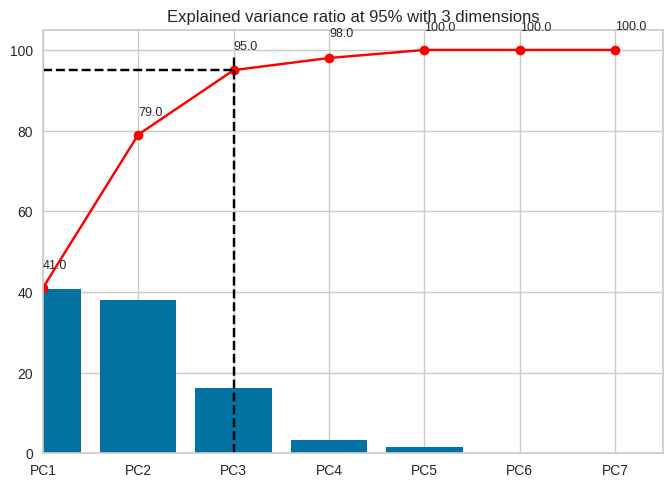

In [11]:
# scaled of data rfmscs
X_scaled = MinMaxScaler().fit_transform(RFM_df_numeric[dict_features['rfmsdis']].copy())

# fit pca and find nb of components explaining more than 95%
model_pca_n =  PCA(n_components=len(dict_features['rfmsdis']))
model_pca_n.fit(X_scaled)
n_compo = np.argmax(np.cumsum(model_pca_n.explained_variance_ratio_) > 0.95) + 1


# éboulie des valeurs à 95% de variance expliquée
n_components = len(dict_features['rfmsdis'])
componants_names = ['PC' + str(n) for n in range(1,n_components+1)]
inertia_weight = (model_pca_n.explained_variance_ratio_*100).round(2)

plt.figure()
plt.title(f"Explained variance ratio at 95% with {n_compo} dimensions")

# plot bars inertia
plt.bar(x=componants_names , height= inertia_weight)

# plot cumulative variance values
plt.plot(np.arange( n_components), inertia_weight.cumsum().round(),c="red",marker='o')

# diplay explained variance values
for i in range(len(inertia_weight)):
  plt.text(x=i, y=inertia_weight.cumsum()[i]+5, s=inertia_weight.cumsum().round()[i], fontsize=9)

# plot horizontale line at 95%
plt.plot(np.linspace(0, n_compo-1, 10), 10 * [95], color='black', linestyle= '--')
# plot verticale line at n_compo
val = np.cumsum(model_pca_n.explained_variance_ratio_)[n_compo]*100
plt.plot(10 * [n_compo-1], np.linspace(0, val, 10), color='black', linestyle= '--')

plt.xlim(0, 6.5)
plt.ylim(0, 105)

plt.grid(True)
plt.show()

Nous conservons 98% des données avec 3 features.

In [131]:
def correlation_graph(pca,
                      x_y,
                      features) :
    """Affiche le graphe des correlations

    Positional arguments :
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.1,
                head_length=0.07,
                width=0.002, )

        # Les labels
        if i%2==0:
          plt.text(pca.components_[x, i] ,
                  pca.components_[y, i] ,
                  features[i],fontsize=9) #+ 0.05
        elif i%2==1:
          plt.text(pca.components_[x, i] ,
                  pca.components_[y, i] + 0.05,
                  features[i],fontsize=9) #+ 0.05

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))


    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

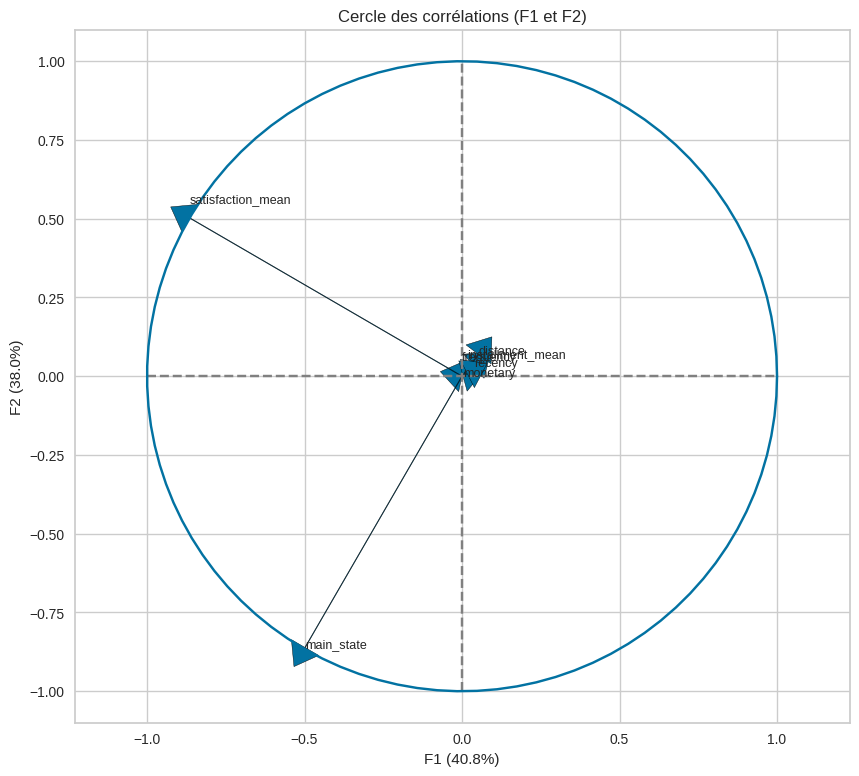

In [133]:
correlation_graph(model_pca_n, (0, 1), dict_features['rfmsdis'])

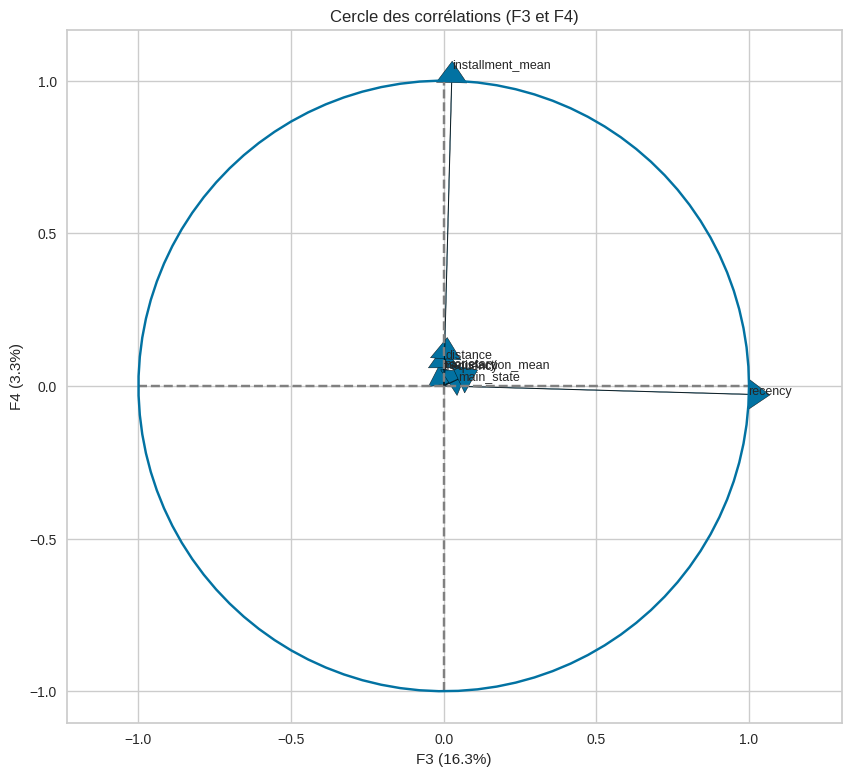

In [134]:
correlation_graph(model_pca_n, (2, 3), dict_features['rfmsdis'])

Nous pouvons interprêter les illustrations de la façon suivante :

La variable synthétique **F1** représente l'aspect **mécontentement**,

La variable synthétique **F2** représente l'aspect **intérêt géographique**,

La variable synthétique **F3** représente la satisfaction **temporel**,

Voyons les résultats de clusters que nous pouvons avoir avec c'est données réduites.

In [13]:
# réduction des données rfmscs à 6 dimensions
model_pca =  PCA(n_components=n_compo)
X_projected = model_pca.fit_transform(X_scaled)

In [14]:
silhouette_pipe = Pipeline([
    ('preprocessor', MinMaxScaler()),
    ('silhouettevisualizer', SilhouetteVisualizer(KMeans(n_clusters=4, random_state=42)))
])
silhouette_pipe.fit(X_projected)
silhouette_pipe.named_steps['silhouettevisualizer'].show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KeyboardInterrupt: 

In [16]:
pipe_pca_treat = Pipeline(
    [('scaling', MinMaxScaler()),
    ('pca', PCA(n_components= n_compo))]
)

data = RFM_df_numeric[dict_features['rfmsdis']].copy()
data_pca = pipe_pca_treat.fit_transform(data)

kmean_pca = KMeans(n_clusters= 4, random_state= 42)

start_time = time()
kmean_pca.fit(data_pca)
end_time = time()

timing_kmean_pca = f'KMeans on pca computed in {round(end_time - start_time)} sec.'

labels = kmean_pca.labels_

interpretation = ["F1 mécontentement",
                  "F2 intérêt géographique",
                  "F3 temporel",
                  "F4 catégories générale d'achats",
                  'F5 financier']
data_pca = pd.DataFrame(data_pca, columns= [x for x in interpretation[:n_compo]])

data_pca['label'] = labels

# Create a dictionary to specify aggregation functions for each column
aggregation_dict = {col: 'mean' for col in data_pca.drop('label', axis=1).columns}  # if col not in cat_features

# Group by 'label' and apply aggregation functions
data_cluster_pca = data_pca.groupby('label').agg(aggregation_dict)

print(timing_kmean_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans on pca computed in 4 sec.


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


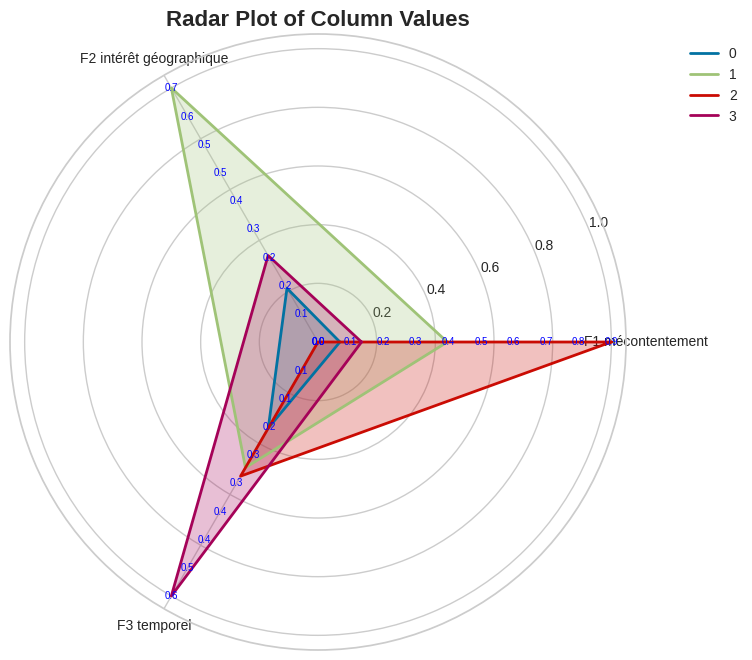

In [17]:
data_cluster_pca_augmente = data_cluster_pca + np.abs(np.min(np.min(data_cluster_pca)))

complex_radar_plot(data_cluster_pca_augmente)

Comparé à l'exécution du KMeans sur les données brutes, les temps d'exécutions sont très proches (1 sec de gagnée seulement).

Cette segmentation semble à première vue très intéressante. On distingue bien les différence entre les groupes. Le bleu par exmple est visuellement le plus intéressant pour la plateforme. C'est le plus récent en date et le plus satisfait et est situé dans une zone géographique très active.

Les autres groupes se distingues plus sur les extrêmes. Par exemple le violet est le plus ancien en date, le vert est situé géographiquement dans une zone peu active et le rouge est très mécontent.

A voir si la pertinence métier est plus satisfaisante que celle des clusters sur données non projetées.

# DBSCAN

In [141]:
# data
data = RFM_df_numeric[dict_features['rfmsdis']].copy()

# Randomly sample from the dataset
sample_size = 5000
sampled_data = data.sample(n=sample_size, random_state=42)

data_scl = StandardScaler().fit_transform(sampled_data)

# Evaluation
avg_silhouette, dt = [], []
epsilon = np.linspace(0.5, 2, 10)
minsamples = np.arange(3, 10)

for eps in tqdm(epsilon):
  for min_s in tqdm(minsamples):

    start_time = time()
    cluster_labels = DBSCAN(eps = eps, min_samples = min_s).fit_predict(data_scl)
    end_time = time()

    dt.append(round(end_time - start_time))

    silh = silhouette_score(data_scl, cluster_labels)
    avg_silhouette.append(silh)

100%|██████████| 10/10 [01:16<00:00,  7.65s/it]


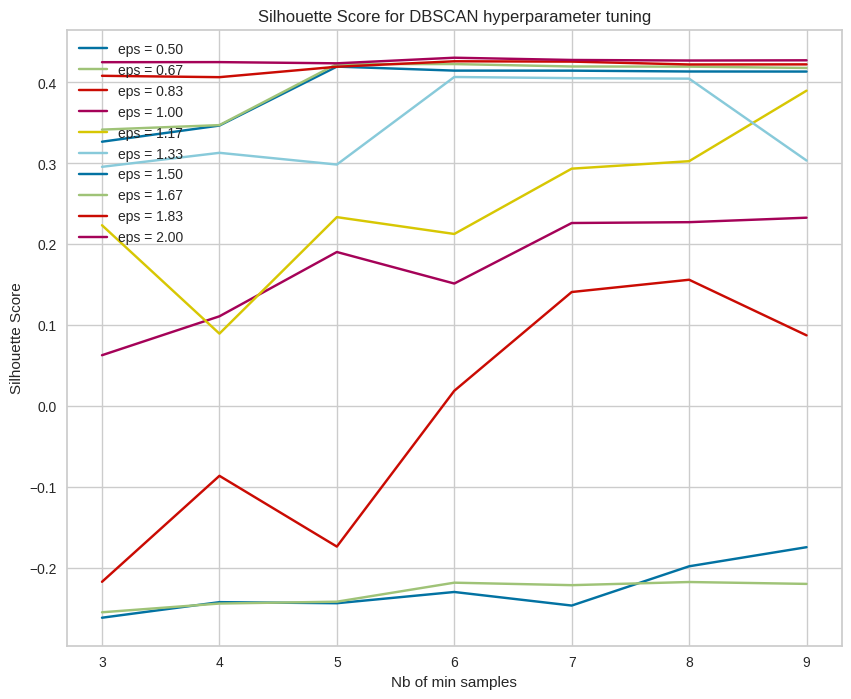

In [142]:
plt.figure(figsize=(10,8))
for idx, eps in enumerate(epsilon):
  plt.plot(minsamples, avg_silhouette[idx*len(minsamples): (idx+1)*len(minsamples)], label='eps = {0:0.2f}'.format(eps))
plt.xlabel('Nb of min samples')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for DBSCAN hyperparameter tuning')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

Pour epsilon égal à 2, min_samples à 4 et une normalisation des données par un standard scaler nous avons un score de silhouette élevé mais nous avons entraîné l'algorythme sur 5000 clients seulement.

100%|██████████| 10/10 [04:15<00:00, 25.56s/it]


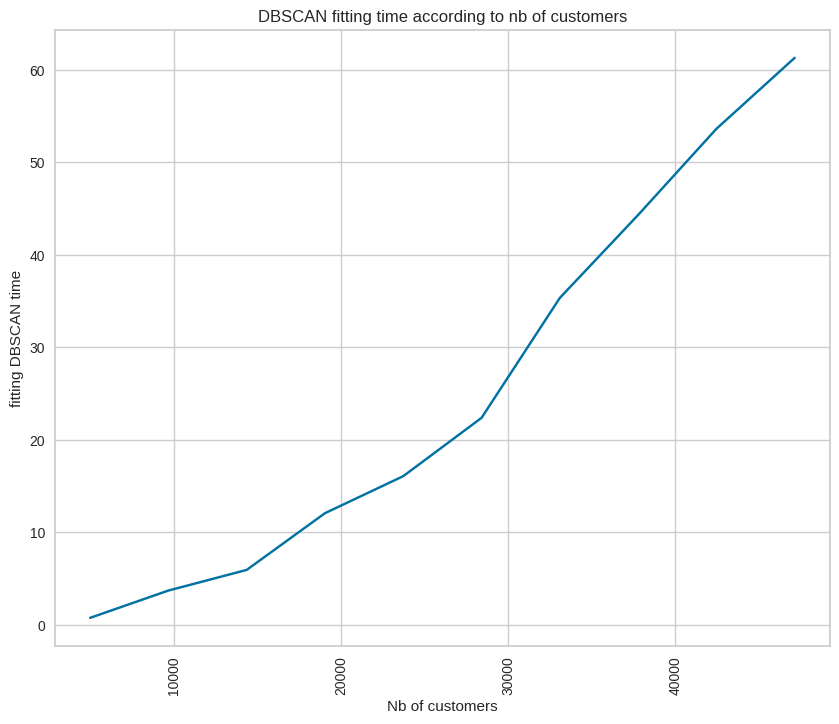

In [143]:
# data
data = RFM_df_numeric[dict_features['rfmsdis']].copy()

nb_customers = np.linspace(5000, data.shape[0]/2, 10)
dt = []

for sample_size in tqdm(nb_customers):

  # Randomly sample from the dataset
  sampled_data = data.sample(n=int(sample_size), random_state=42)
  data_scl = StandardScaler().fit_transform(sampled_data)

  start_time = time()
  clust = DBSCAN(eps = 2, min_samples = 4).fit_predict(data_scl)
  end_time = time()

  dt.append(round(end_time - start_time, 2))

plt.figure(figsize=(10,8))
plt.plot(nb_customers, dt)
plt.xticks(rotation = 90)
plt.xlabel('Nb of customers')
plt.ylabel('fitting DBSCAN time')
plt.title('DBSCAN fitting time according to nb of customers')
plt.grid(True)
plt.show()

Les scores de silhouette et les temps de calcul du DBSCAN sont clairement moins intéressant que le KMeans.

# AgglomerativeClustering

Comparons avec un AgglomerativeClustering.

In [144]:
# data
data = RFM_df_numeric[dict_features['rfmsdis']].copy()

# Randomly sample from the dataset
sample_size = 10000
sampled_data = data.sample(n=sample_size, random_state=42)

avg_silhouette, avg_calinski_harabasz, dt = [], [], []

for n in tqdm(range(3, 8)):

  scl = MinMaxScaler().fit_transform(sampled_data)

  start_time = time()
  cluster_labels = AgglomerativeClustering(n_clusters=n).fit_predict(scl)
  end_time = time()

  dt.append(round(end_time - start_time))

  silh = silhouette_score(sampled_data, cluster_labels)
  avg_silhouette.append(silh)

  calin = calinski_harabasz_score(sampled_data, cluster_labels)
  avg_calinski_harabasz.append(calin)

Bestcalin = np.max(avg_calinski_harabasz)
arg_calin = np.argmax(avg_calinski_harabasz == Bestcalin)

Bestsilh = np.max(avg_silhouette)
arg_silh = np.argmax(avg_silhouette == Bestsilh)

list_n = [n for n in range(3, 8)]

display(f'best calinski_harabasz = {Bestcalin}, for n_clusters = {list_n[arg_calin]} in {dt[arg_calin]} sec.')
display(f'best silhouette_score = {Bestsilh}, for n_clusters = {list_n[arg_silh]} in {dt[arg_silh]} sec.')

100%|██████████| 5/5 [00:40<00:00,  8.11s/it]


'best calinski_harabasz = 761.6994096797388, for n_clusters = 5 in 5 sec.'

'best silhouette_score = 0.09138475386098369, for n_clusters = 3 in 6 sec.'

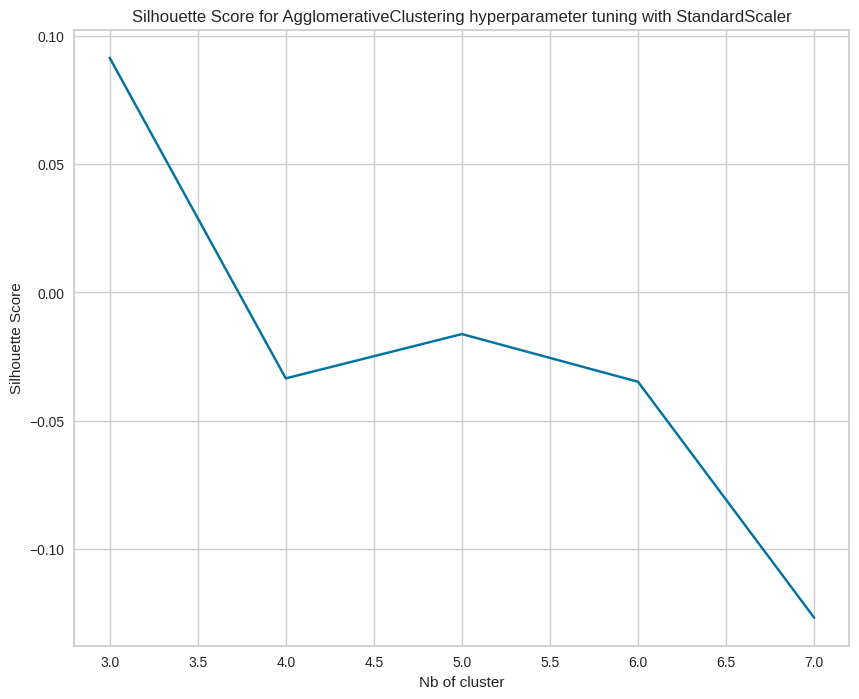

In [145]:
plt.figure(figsize=(10,8))
plt.plot(range(3, 8), avg_silhouette)
plt.xlabel('Nb of cluster')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for AgglomerativeClustering hyperparameter tuning with StandardScaler')
plt.grid(True)
plt.show()

In [146]:
# data
data = RFM_df_numeric[dict_features['rfmsdis']].copy()

# Randomly sample from the dataset
sample_size = 10000
sampled_data = data.sample(n=sample_size, random_state=42)

avg_silhouette, avg_calinski_harabasz, dt = [], [], []

for n in range(3, 8):

  scl = StandardScaler().fit_transform(sampled_data)

  start_time = time()
  cluster_labels = AgglomerativeClustering(n_clusters=n).fit_predict(scl)
  end_time = time()

  dt.append(round(end_time - start_time))

  silh = silhouette_score(sampled_data, cluster_labels)
  avg_silhouette.append(silh)

  calin = calinski_harabasz_score(sampled_data, cluster_labels)
  avg_calinski_harabasz.append(calin)

Bestcalin = np.max(avg_calinski_harabasz)
arg_calin = np.argmax(avg_calinski_harabasz == Bestcalin)

Bestsilh = np.max(avg_silhouette)
arg_silh = np.argmax(avg_silhouette == Bestsilh)

list_n = [n for n in range(3, 8)]

display(f'best calinski_harabasz = {Bestcalin}, for n_clusters = {list_n[arg_calin]} in {dt[arg_calin]} sec.')
display(f'best silhouette_score = {Bestsilh}, for n_clusters = {list_n[arg_silh]} in {dt[arg_silh]} sec.')

'best calinski_harabasz = 1374.1192481993548, for n_clusters = 3 in 5 sec.'

'best silhouette_score = 0.08200839086371929, for n_clusters = 3 in 5 sec.'

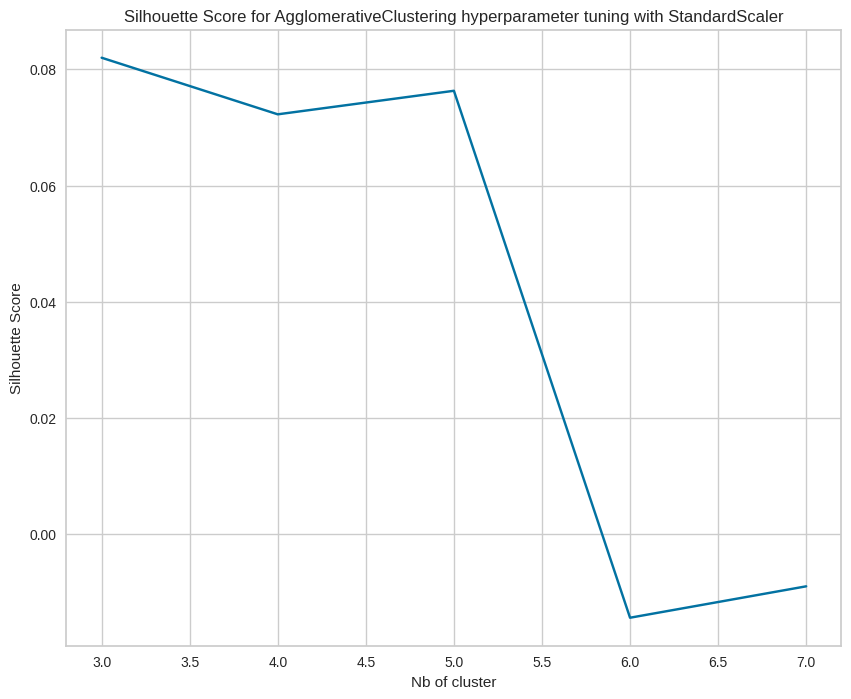

In [147]:
plt.figure(figsize=(10,8))
plt.plot(range(3, 8), avg_silhouette)
plt.xlabel('Nb of cluster')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for AgglomerativeClustering hyperparameter tuning with StandardScaler')
plt.grid(True)
plt.show()

Sans normalisation :

In [148]:
# data
data = RFM_df_numeric[dict_features['rfmsdis']].copy()

# Randomly sample from the dataset
sample_size = 10000
sampled_data = data.sample(n=sample_size, random_state=42)

avg_silhouette, avg_calinski_harabasz, dt = [], [], []

for n in tqdm(range(3, 8)):

  start_time = time()
  cluster_labels = AgglomerativeClustering(n_clusters=n).fit_predict(sampled_data)
  end_time = time()

  dt.append(round(end_time - start_time))

  silh = silhouette_score(sampled_data, cluster_labels)
  avg_silhouette.append(silh)

  calin = calinski_harabasz_score(sampled_data, cluster_labels)
  avg_calinski_harabasz.append(calin)

Bestcalin = np.max(avg_calinski_harabasz)
arg_calin = np.argmax(avg_calinski_harabasz == Bestcalin)

Bestsilh = np.max(avg_silhouette)
arg_silh = np.argmax(avg_silhouette == Bestsilh)

list_n = [n for n in range(3, 8)]

display(f'best calinski_harabasz = {Bestcalin}, for n_clusters = {list_n[arg_calin]} in {dt[arg_calin]} sec.')
display(f'best silhouette_score = {Bestsilh}, for n_clusters = {list_n[arg_silh]} in {dt[arg_silh]} sec.')

100%|██████████| 5/5 [00:33<00:00,  6.80s/it]


'best calinski_harabasz = 11496.144234405347, for n_clusters = 3 in 5 sec.'

'best silhouette_score = 0.4720321311777135, for n_clusters = 4 in 4 sec.'

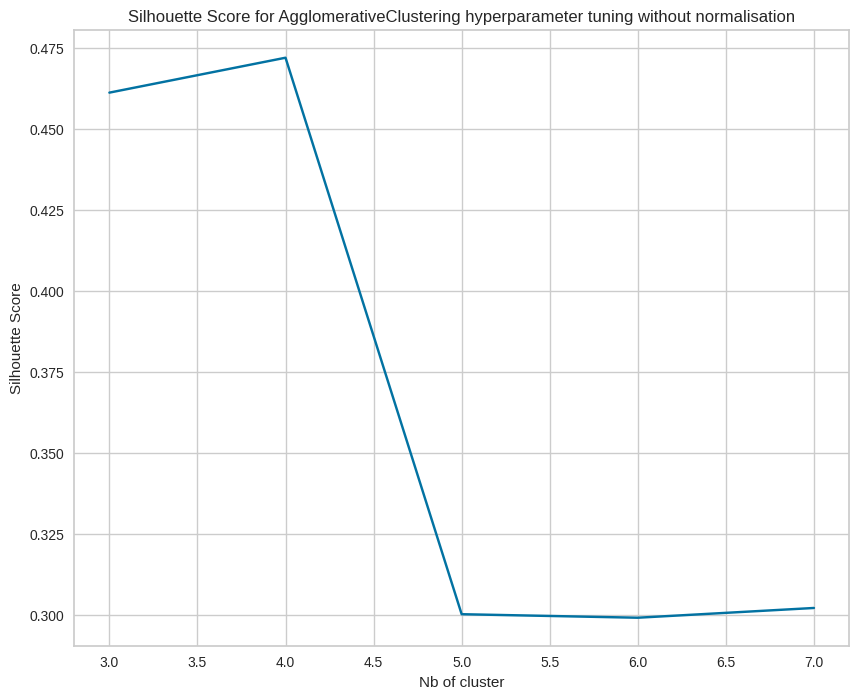

In [149]:
plt.figure(figsize=(10,8))
plt.plot(range(3, 8), avg_silhouette)
plt.xlabel('Nb of cluster')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for AgglomerativeClustering hyperparameter tuning without normalisation')
plt.grid(True)
plt.show()

Temps de calcul selon quantité de données d'entraînement :

In [150]:
# data
data = RFM_df_numeric[dict_features['rfmsdis']].copy()

nb_customers = np.linspace(5000, data.shape[0]*0.3, 10) # 30% des données max
dt = []

for sample_size in tqdm(nb_customers):

  # Randomly sample from the dataset
  sampled_data = data.sample(n=int(sample_size), random_state=42)
  data_scl = StandardScaler().fit_transform(sampled_data)

  start_time = time()
  clust = AgglomerativeClustering(n_clusters=3).fit_predict(data_scl)
  end_time = time()

  dt.append(round(end_time - start_time, 2))

100%|██████████| 10/10 [04:30<00:00, 27.05s/it]


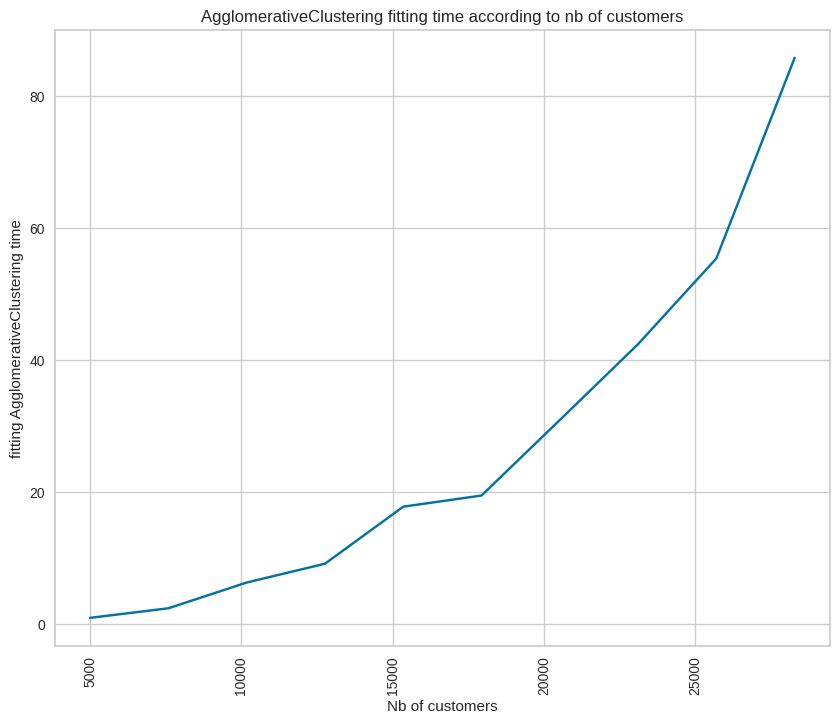

In [151]:
plt.figure(figsize=(10,8))
plt.plot(nb_customers, dt)
plt.xticks(rotation = 90)
plt.xlabel('Nb of customers')
plt.ylabel('fitting AgglomerativeClustering time')
plt.title('AgglomerativeClustering fitting time according to nb of customers')
plt.grid(True)
plt.show()

Sur les données brutes sans normalisation les score des cluster calculés par AgglomerativeClustering sembles plus intéressants mais les temps de calculs sont incomparables au KMeans. Sur la moitié des données le temps de calcul dépasse la minutes pour l'AglomerativeClustering là où l'on est à la seconde pour le KMeans.

Le KMeans reste le meilleur avec les données dont nous disposons pour réaliser notre segmentation.